# **Exercice Python - Voitures**

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cars_path = "used_cars_data.csv"
df = pd.read_csv(cars_path, sep=",")

################################################################################################
# FILTRES POUR HOMOGENEISER ET FIABILISER LES DONNEES
################################################################################################
df = df[df["bed"].isna()]
df = df[df["cabin"].isna()]
df = df[df["frame_damaged"] != True]
df = df[df["has_accidents"] != True]
df = df[df["isCab"] != True]
df = df[~df["main_picture_url"].isna()]
df = df[(df["owner_count"].isna()) | (df["owner_count"] == 1)]
df = df[df["salvage"] != True]
df = df[df["theft_title"] != True]
df = df[df["daysonmarket"] < 365]

df = df.drop(["bed", "bed_height", "cabin", "city", "dealer_zip",
              "description", "exterior_color", "has_accidents", "interior_color",
              "isCab", "frame_damaged", "latitude", "longitude", "main_picture_url", "owner_count",
              "is_certified", "is_cpo", "salvage", "savings_amount", "seller_rating", "sp_id", "theft_title",
              "vehicle_damage_category"], axis=1)

df.to_csv("used_cars_data_shorter.csv", index=False)

print(f"Fichier prêt")

In [5]:
cars_path = "used_cars_data_shorter.csv"
df = pd.read_csv(cars_path, sep=",")

target = 'price'
X = df.drop(target, axis=1)
y = df[target]

SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# On enregistre le Train et le Test sous CSV
train_full = X_train.copy()
train_full[target] = y_train
train_full.to_csv("used_cars_data_shorter_train.csv", index=False)

test_full = X_test.copy()
test_full[target] = y_test
test_full.to_csv("used_cars_data_shorter_test.csv", index=False)

print(f"Fichiers prêts")

Fichiers prêts


## **Analyse exploratoire des données (EDA)**

On travaillera sur le train directement et on appliquera ces changements au test (via une fonction qu'on va créer plus tard pour plus de rapidité)

### **1.1 Observations générales et traitement**

In [ ]:
train_full = pd.read_csv("used_cars_data_shorter_train.csv")
target = 'price'
y_train = train_full[target]
X_train = train_full.drop(target, axis=1)
print(f"Taille du train : {train_full.shape}")

Taille du train : (1451463, 43)


In [ ]:
print(X_train.info())
missing_rate = (X_train.isnull().sum() / len(X_train)) * 100
print(missing_rate.sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451463 entries, 0 to 1451462
Data columns (total 42 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   vin                   1451463 non-null  object 
 1   back_legroom          1377245 non-null  object 
 2   bed_length            204370 non-null   object 
 3   body_type             1443875 non-null  object 
 4   city_fuel_economy     1233082 non-null  float64
 5   combine_fuel_economy  0 non-null        float64
 6   daysonmarket          1451463 non-null  int64  
 7   engine_cylinders      1405196 non-null  object 
 8   engine_displacement   1366395 non-null  float64
 9   engine_type           1405196 non-null  object 
 10  fleet                 541424 non-null   object 
 11  franchise_dealer      1451463 non-null  bool   
 12  franchise_make        1323122 non-null  object 
 13  front_legroom         1377245 non-null  object 
 14  fuel_tank_volume      1377245 non-

On effectue un premier tri général avec ces premières obervations : suppression de colonnes trop vides, id, doublons, corrections de types (grâce à l'observation visuelle, nous avons pu remarqué que certains types 'object' (sûrement str) doivent être 'float')

In [6]:
# Suppresion des colonnes : trop de vides (> 60%) + identifiants + colonnes similaires/identiques
cols_to_drop = ["combine_fuel_economy", "is_oemcpo", "bed_length", "fleet", "vin", "listing_id","trimId", "engine_type", "wheel_system_display"]
X_train = X_train.drop(columns=cols_to_drop)
print(f" Nombre colonnes après suppression : {X_train.shape[1]}")

# Doublons
initial_count = len(X_train)
X_train = X_train.drop_duplicates()
print(f"Doublons supprimés : {initial_count - len(X_train)}")

# Suppression des colonnes 'object' qui devraient être 'float'
cols_to_fix = ['back_legroom', 'front_legroom', 'fuel_tank_volume','height', 'length', 'width', 'wheelbase', 'maximum_seating']
def clean_numeric(value):
    if pd.isna(value):
        return np.nan
        #après observations
    res = re.sub(r'[^0-9.]', '', str(value))
    return float(res) if res != '' else np.nan
for col in cols_to_fix:
    X_train[col] = X_train[col].apply(clean_numeric)

print("Vérification des nouveaux types :")
print(X_train[cols_to_fix].dtypes)


 Nombre colonnes après suppression : 33
Doublons supprimés : 50698
Vérification des nouveaux types :
back_legroom        float64
front_legroom       float64
fuel_tank_volume    float64
height              float64
length              float64
width               float64
wheelbase           float64
maximum_seating     float64
dtype: object


Traitement d'une autre anomalie générale concernant 2 colonnes : deux variables qui sont encore en object alors qu'elles devraient être numériques : power (la puissance) et torque (le couple). Comme ces colonnes contiennent souvent du texte (ex: "300 hp @ 6000 rpm"), on va extraire uniquement le premier nombre.

In [7]:
def extract_first_num(value):
    if pd.isna(value):
        return np.nan
    # On cherche le 1er groupe de chiffres
    match = re.search(r'(\d+)', str(value))
    if match:
        return float(match.group(1))
    return np.nan

X_train['power'] = X_train['power'].apply(extract_first_num)
X_train['torque'] = X_train['torque'].apply(extract_first_num)

print("Vérification :")
print(X_train[['power', 'torque']].dtypes)
print(X_train[['power', 'torque']].head(10))

Vérification :
power     float64
torque    float64
dtype: object
         power  torque
686530   181.0   175.0
1798515    NaN     NaN
731399   385.0   430.0
653654     NaN     NaN
1325558    NaN     NaN
1703993  300.0   264.0
232501   192.0   192.0
980548   170.0   203.0
94694    170.0   175.0
281826   310.0   266.0


##**1.2 - EDA**

Statistiques descriptives

In [ ]:
display(X_train.describe())

,back_legroom,city_fuel_economy,daysonmarket,engine_displacement,front_legroom,fuel_tank_volume,height,highway_fuel_economy,horsepower,length,maximum_seating,mileage,power,torque,wheelbase,width,year
count,1.293877e+06,1.192664e+06,1.400765e+06,1.320850e+06,1.323410e+06,1.330883e+06,1.331121e+06,1.192664e+06,1.320850e+06,1.331123e+06,1.331114e+06,1.332270e+06,1.151893e+06,1.136125e+06,1.331136e+06,1.331122e+06,1.400765e+06
mean,3.814924e+01,2.330190e+01,7.708588e+01,2.857400e+03,4.220284e+01,1.831199e+01,6.602504e+01,2.989907e+01,2.474828e+02,1.932297e+02,5.459036e+00,1.559593e+04,2.511081e+02,2.644973e+02,1.151798e+02,7.872036e+01,2.018829e+03
std,3.024725e+00,9.481142e+00,8.595350e+01,1.305394e+03,1.508603e+00,5.298730e+00,7.382197e+00,8.093388e+00,9.098271e+01,2.019233e+01,1.105136e+00,2.943176e+04,9.096381e+01,1.181681e+02,1.443100e+01,7.776910e+00,3.181379e+00
min,0.000000e+00,8.000000e+00,0.000000e+00,7.000000e+02,2.900000e+01,1.900000e+00,4.370000e+01,1.100000e+01,5.500000e+01,1.061000e+02,2.000000e+00,0.000000e+00,5.500000e+01,5.800000e+01,7.350000e+01,5.700000e+01,1.915000e+03
25%,3.610000e+01,1.800000e+01,1.800000e+01,2.000000e+03,4.100000e+01,1.450000e+01,5.830000e+01,2.500000e+01,1.750000e+02,1.819000e+02,5.000000e+00,5.000000e+00,1.750000e+02,1.760000e+02,1.063000e+02,7.250000e+01,2.018000e+03
50%,3.830000e+01,2.200000e+01,4.100000e+01,2.500000e+03,4.200000e+01,1.720000e+01,6.610000e+01,2.900000e+01,2.410000e+02,1.898000e+02,5.000000e+00,1.200000e+01,2.500000e+02,2.580000e+02,1.112000e+02,7.810000e+01,2.020000e+03
75%,3.990000e+01,2.600000e+01,9.400000e+01,3.500000e+03,4.310000e+01,2.100000e+01,7.010000e+01,3.300000e+01,3.000000e+02,1.988000e+02,6.000000e+00,2.334500e+04,3.100000e+02,3.200000e+02,1.184000e+02,8.350000e+01,2.020000e+03
max,5.980000e+01,1.270000e+02,3.640000e+02,8.400000e+03,6.700000e+01,6.400000e+01,1.176000e+02,1.270000e+02,9.490000e+02,2.900000e+02,1.500000e+01,1.225238e+06,9.490000e+02,9.440000e+02,2.010000e+02,1.090000e+02,2.021000e+03


Visualisations univariées

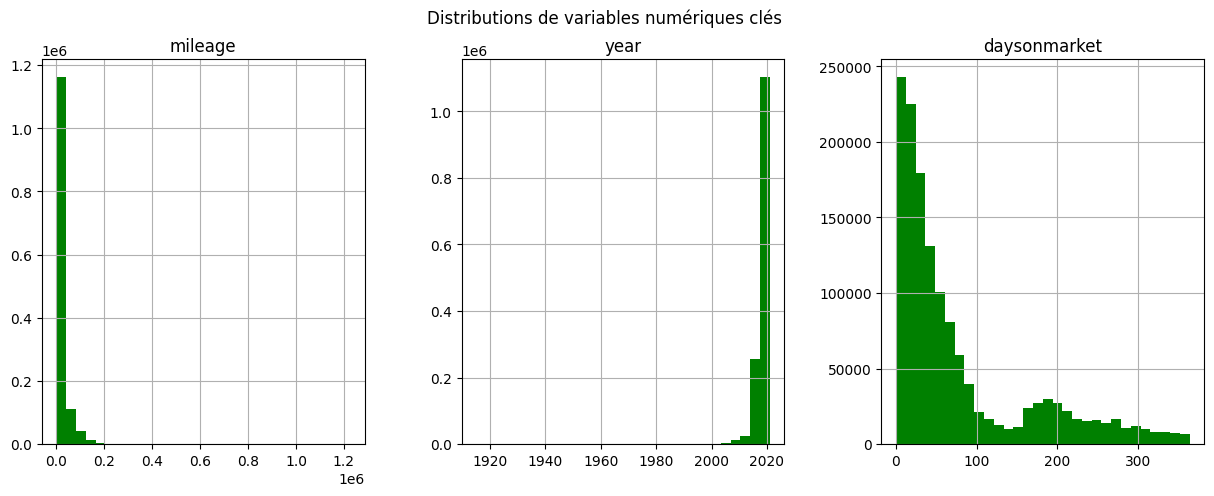

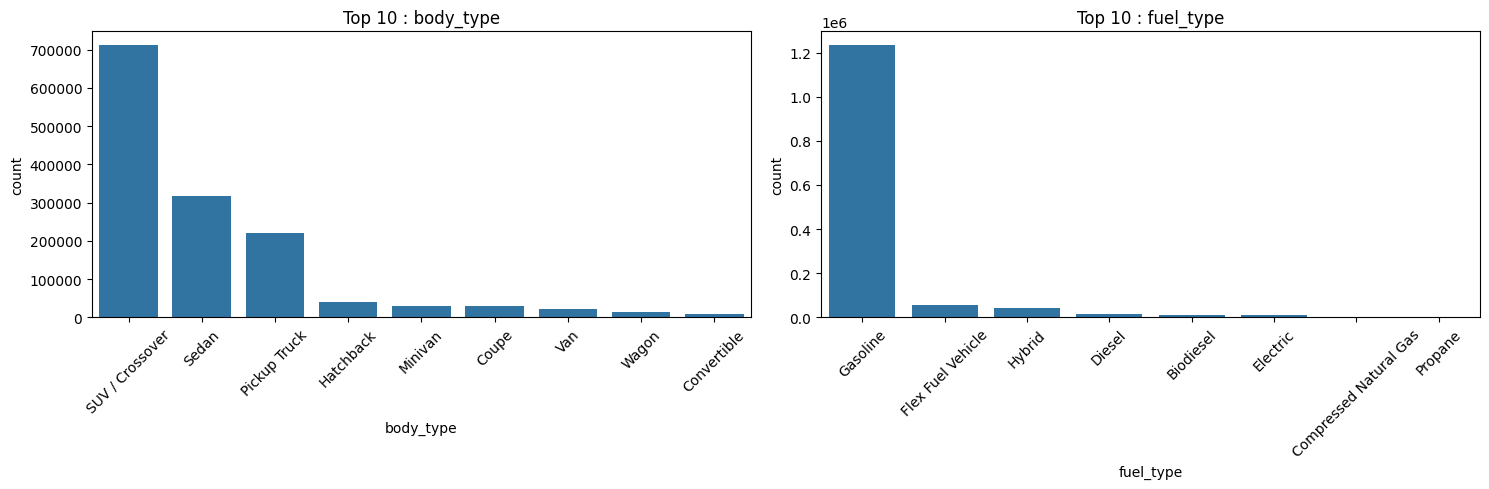

In [ ]:
# On choisit quelques variables clés selon la target qui est ici le prix
features_num = ['mileage', 'year', 'daysonmarket']
features_cat = ['body_type', 'fuel_type']

# Histogrammes numérique
X_train[features_num].hist(bins=30, figsize=(15, 5), layout=(1, 3), color='green')
plt.suptitle('Distributions de variables numériques clés')
plt.show()

# Graphiques à barres pour les catégories
plt.figure(figsize=(15, 5))
for i, col in enumerate(features_cat):
    plt.subplot(1, 2, i+1)
    sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index[:10])
    plt.xticks(rotation=45)
    plt.title(f'Top 10 : {col}')
plt.tight_layout()
plt.show()

- Kilométrage (mileage) : On voit une distribution asymétrique avec une forte concentration sous les 100000 km. La 'longue traîne' -> des outliers à traiter pour ne pas biaiser le modèle.
- Année (year) : Il y a une prédominance de véhicules récents (post-2015). Le modèle sera plus précis sur le moderne que sur les véhicules de collection.
- Marques & carrosserie : lE marché dominé par les SUV et les marques généralistes (Ford, Toyota). La haute cardinalité des marques nécessitera un regroupement.

Visualisations bivariées : relations avec le prix

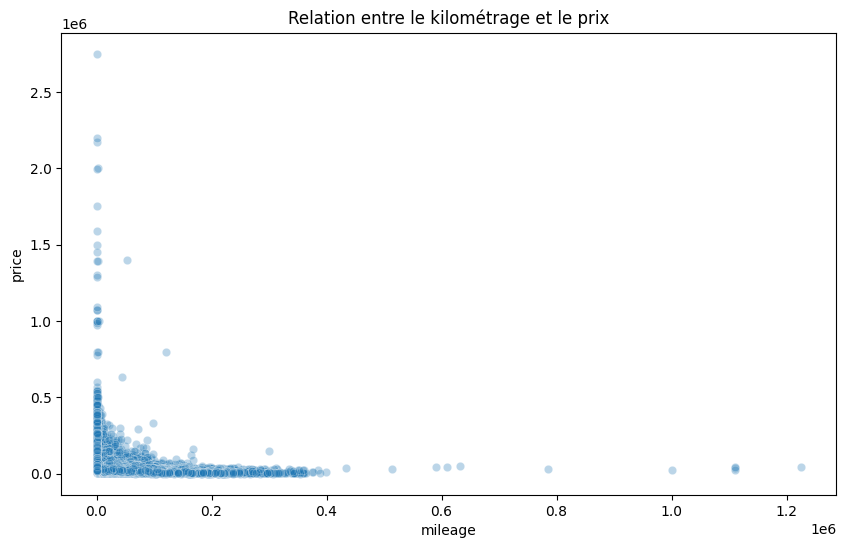

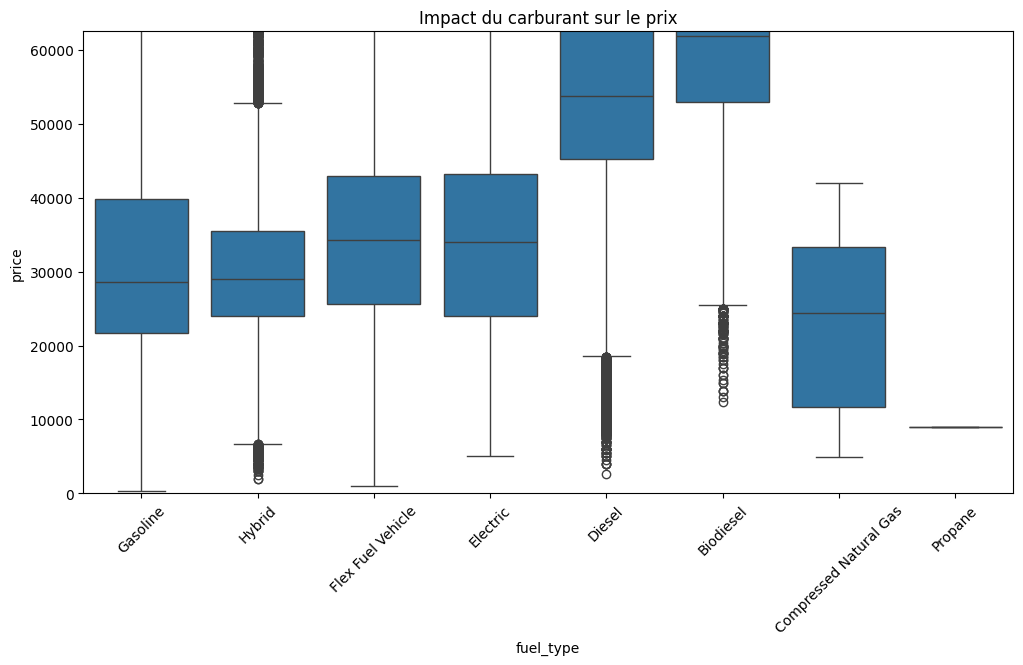

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train['mileage'], y=y_train, alpha=0.3)
plt.title('Relation entre le kilométrage et le prix')
plt.show()

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x=X_train['fuel_type'], y=y_train)
plt.title('Impact du carburant sur le prix')
plt.xticks(rotation=45)
plt.ylim(0, y_train.quantile(0.95)) # On coupe le top 5% pour mieux voir le gros des données
plt.show()

Top corrélations avec price
price                   1.000000
horsepower              0.672816
power                   0.638191
torque                  0.599450
fuel_tank_volume        0.480040
engine_displacement     0.456369
length                  0.423490
width                   0.421992
wheelbase               0.413114
height                  0.321482
back_legroom            0.314082
is_new                  0.269980
year                    0.202248
maximum_seating         0.174521
franchise_dealer        0.162684
daysonmarket            0.080726
front_legroom           0.072587
city_fuel_economy      -0.230023
highway_fuel_economy   -0.311187
mileage                -0.326815
Name: price, dtype: float64


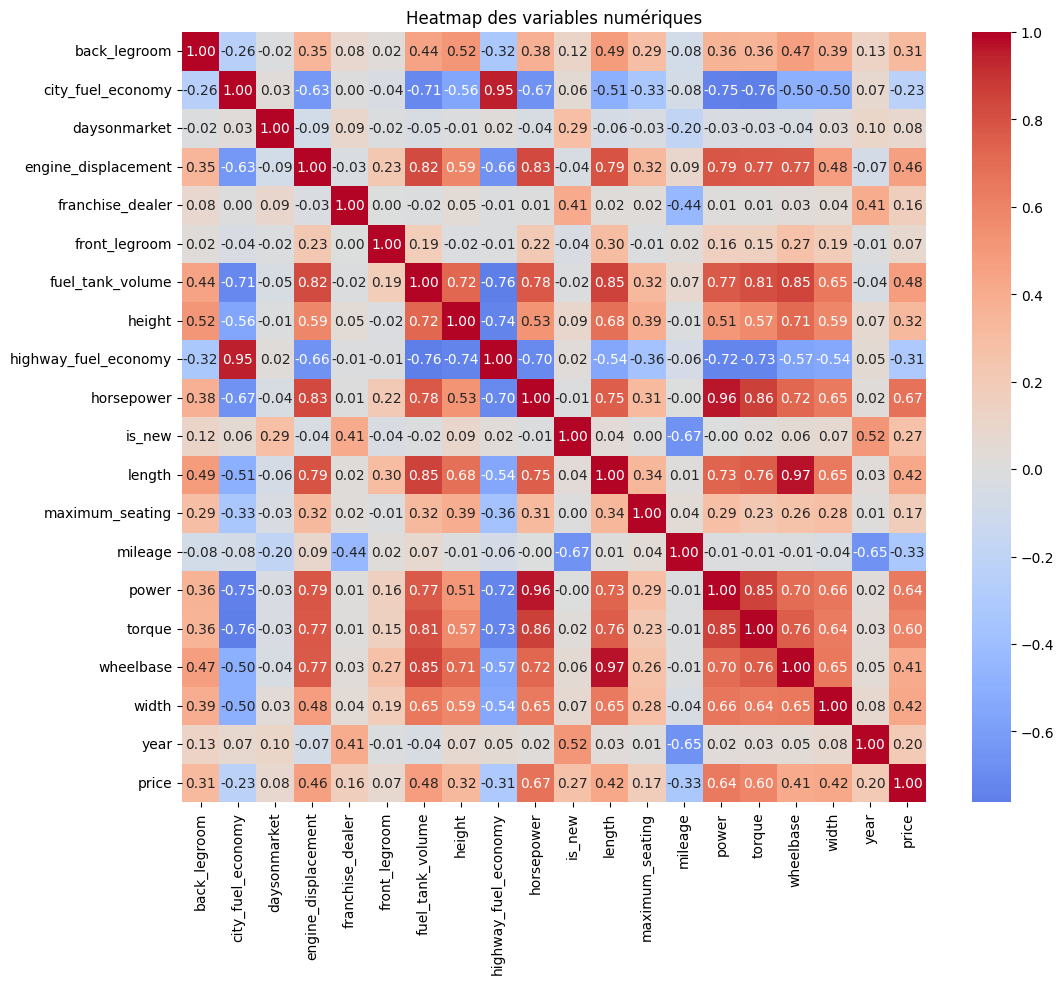

In [ ]:
num_cols = X_train.select_dtypes(include=['number', 'bool']).columns
df_corr = X_train[num_cols].copy()
df_corr['price'] = y_train

corrs = df_corr.corr()['price'].sort_values(ascending=False)
print("Top corrélations avec price")
print(corrs)

plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Heatmap des variables numériques")
plt.show()

D'après les graphiques et la matrice de corrélation, on tire les conclusions suivantes :

- Usure mécanique : Le prix et le kilométrage ont une corrélation négative de 0,33. C'est logique : plus une voiture roule, plus sa valeur chute. C'est un facteur de prédiction indispensable.
- Performance moteur : La puissance (horsepower) est le plus gros levier du prix avec un score de 0,67. C'est la variable numérique la plus influente de notre dataset.
- Gabarit du véhicule : Les dimensions (length, width, wheelbase) et le volume du réservoir tournent autour de 0,45.
- Les véhicules massifs (SUV, pick-up) sont nettement mieux valorisés.
- Consommation : On note une corrélation négative avec l'efficience carburant (-0,31). EDonc les voitures les plus économes sont souvent les citadines d'entrée de gamme, donc les moins chères.

**Multicolinéarité**

In [ ]:
# Calcul de la matrice de corrélation (uniquement sur les numériques)
X_train_num = X_train.select_dtypes(include=['number', 'bool'])
corr_matrix = X_train_num.corr().abs()

# On ne regarde que la partie supérieure de la matrice (pour éviter les doublons A-B / B-A)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Trouver les colonnes avec une corrélation > 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

print("Variables fortement corrélées entre elles (> 0.70)")
if len(to_drop) > 0:
    for col in to_drop:
        # Trouver avec quelle variable elle est corrélée
        correlated_with = upper.index[upper[col] > 0.70].tolist()
        print(f"'{col}' est corrélée avec {correlated_with}")
else:
    print("Aucune variable ne dépasse 70% de corrélation")

Variables fortement corrélées entre elles (> 0.70)
'fuel_tank_volume' est corrélée avec ['city_fuel_economy', 'engine_displacement']
'height' est corrélée avec ['fuel_tank_volume']
'highway_fuel_economy' est corrélée avec ['city_fuel_economy', 'fuel_tank_volume', 'height']
'horsepower' est corrélée avec ['engine_displacement', 'fuel_tank_volume', 'highway_fuel_economy']
'length' est corrélée avec ['engine_displacement', 'fuel_tank_volume', 'horsepower']
'power' est corrélée avec ['city_fuel_economy', 'engine_displacement', 'fuel_tank_volume', 'highway_fuel_economy', 'horsepower', 'length']
'torque' est corrélée avec ['city_fuel_economy', 'engine_displacement', 'fuel_tank_volume', 'highway_fuel_economy', 'horsepower', 'length', 'power']
'wheelbase' est corrélée avec ['engine_displacement', 'fuel_tank_volume', 'height', 'horsepower', 'length', 'torque']


L'analyse de corrélation montre que beaucoup de variables sont redondantes (multicolinéarité > 70%). Pour simplifier le modèle et éviter le sur-apprentissage, on ne garde que la variable la plus forte de chaque groupe (ex: horsepower). On passe ainsi d'un dataset complexe à un dataset plus robuste et facile à interpréter.

In [8]:
# Retirer les variables > 70% de corrélation

cols_to_drop = ['power', 'torque', 'engine_displacement', 'highway_fuel_economy', 'width', 'wheelbase', 'height', 'fuel_tank_volume', "trim_name"]
#Redondance avec horsepower,highway_fuel_economy,length

X_train = X_train.drop(columns=cols_to_drop)

print(f"Colonnes restantes : {X_train.shape[1]}")

Colonnes restantes : 24


In [ ]:
# Vérification finale avant analyse des variables
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1400765 entries, 0 to 1451462
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   back_legroom          1293877 non-null  float64
 1   body_type             1393809 non-null  object 
 2   city_fuel_economy     1192664 non-null  float64
 3   daysonmarket          1400765 non-null  int64  
 4   engine_cylinders      1357711 non-null  object 
 5   franchise_dealer      1400765 non-null  bool   
 6   franchise_make        1272576 non-null  object 
 7   front_legroom         1323410 non-null  float64
 8   fuel_type             1368208 non-null  object 
 9   horsepower            1320850 non-null  float64
 10  is_new                1400765 non-null  bool   
 11  length                1331123 non-null  float64
 12  listed_date           1400765 non-null  object 
 13  listing_color         1400765 non-null  object 
 14  major_options         1318901 non-null 

In [9]:
# DataFrame numérique (inclut float, int, bool)
X_train_num = X_train.select_dtypes(include=['number', 'bool'])

# DataFrame catégoriel (les objets/colonnes de texte)
X_train_cat = X_train.select_dtypes(include=['object'])

print(f"Numérique : {X_train_num.shape[1]} colonnes")
print(f"Catégoriel : {X_train_cat.shape[1]} colonnes")

X_train_num.to_csv('X_train_numeric.csv', index=False)
X_train_cat.to_csv('X_train_categorical.csv', index=False)

print("Fichiers sauvegardés")

Numérique : 11 colonnes
Catégoriel : 13 colonnes
Fichiers sauvegardés


In [10]:
print(X_train_num.info())
print(X_train_cat.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1400765 entries, 686530 to 121958
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   back_legroom       1293877 non-null  float64
 1   city_fuel_economy  1192664 non-null  float64
 2   daysonmarket       1400765 non-null  int64  
 3   franchise_dealer   1400765 non-null  bool   
 4   front_legroom      1323410 non-null  float64
 5   horsepower         1320850 non-null  float64
 6   is_new             1400765 non-null  bool   
 7   length             1331123 non-null  float64
 8   maximum_seating    1331114 non-null  float64
 9   mileage            1332270 non-null  float64
 10  year               1400765 non-null  int64  
dtypes: bool(2), float64(7), int64(2)
memory usage: 109.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1400765 entries, 686530 to 121958
Data columns (total 13 columns):
 #   Column                Non-Null Count    Dtype 
---  ---

# **Pre-processing et Feature Engineering**

Pour garantir la qualité du dataset, j'ai choisi d'adopter une approche granulaire en traitant chaque variable individuellement.
Pour chaque caractéristique, le processus inclut la correction des formats (qualité des données), l'imputation ciblée des valeurs manquantes (médiane pour le numérique, mode ou 'Unknown' pour le catégoriel) et la détection des valeurs aberrantes via boxplots. Cette méthode permet d'appliquer un traitement spécifique à la nature de chaque donnée (Capping, suppression ou correction) avant la phase de modélisation.

### **1 - LES VARIABLES NUMÉRIQUES**

 `back_legroom`

Diagnostic complet de back_legroom
count    1.293877e+06
mean     3.814924e+01
std      3.024725e+00
min      0.000000e+00
25%      3.610000e+01
50%      3.830000e+01
75%      3.990000e+01
max      5.980000e+01
Name: back_legroom, dtype: float64
Valeurs manquantes : 106888 (7.63%)


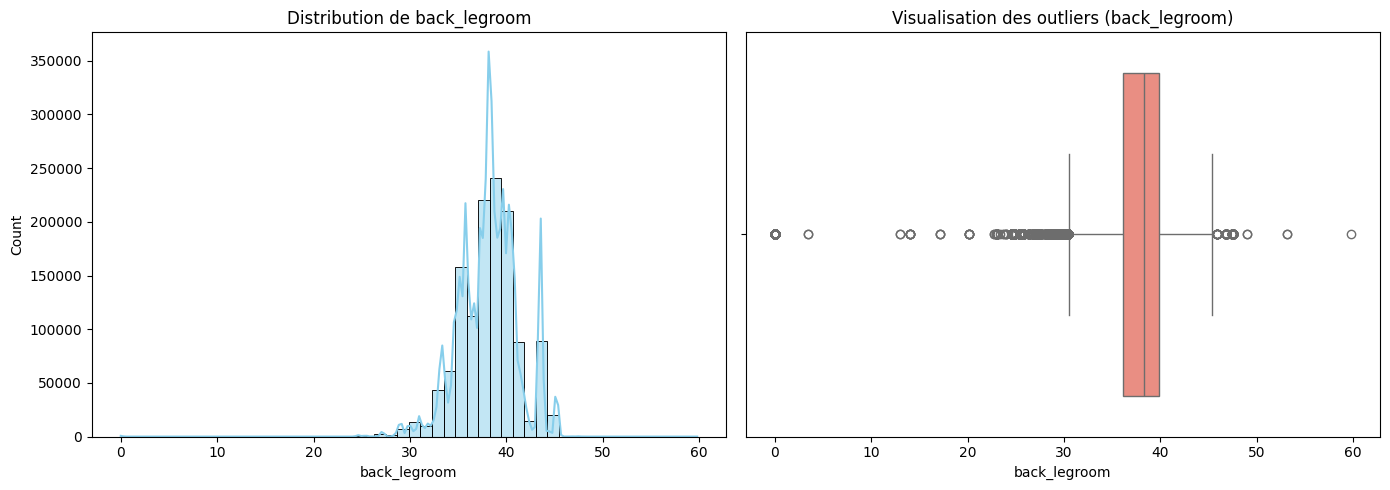

In [ ]:
var = 'back_legroom'

print(f"Diagnostic complet de {var}")
print(X_train_num[var].describe())
plt.figure(figsize=(14, 5))

# Analyse des manquants
null_count = X_train_num[var].isna().sum()
null_pct = (null_count / len(X_train_num)) * 100
print(f"Valeurs manquantes : {null_count} ({null_pct:.2f}%)")

# Distribution (histo)
plt.subplot(1, 2, 1)
sns.histplot(X_train_num[var].dropna(), kde=True, bins=50, color='skyblue')
plt.title(f"Distribution de {var}")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=X_train_num[var], color='salmon')
plt.title(f"Visualisation des outliers ({var})")
plt.tight_layout()
plt.show()

In [11]:
# Nettoyage : back_legroom

# Traitement des valeurs impossibles (0.0) et aberrantes (trop hautes)
# On transforme en NaN pour tout traiter d'un coup
X_train_num.loc[X_train_num['back_legroom'] <= 0, 'back_legroom'] = np.nan
X_train_num.loc[X_train_num['back_legroom'] > 45, 'back_legroom'] = np.nan

# Calcul de la médiane sur les données réalistes
back_legroom_median = X_train_num['back_legroom'].median()
print(f"Valeur d'imputation (médiane) : {back_legroom_median}")

# Remplissage des valeurs manquantes et aberrantes
X_train_num['back_legroom'] = X_train_num['back_legroom'].fillna(back_legroom_median)

# Vérification finale
print(f"Manquants après imputation : {X_train_num['back_legroom'].isna().sum()}")
print(f"Valeur max après nettoyage : {X_train_num['back_legroom'].max()}")

Valeur d'imputation (médiane) : 38.3
Manquants après imputation : 0
Valeur max après nettoyage : 44.5


Observation de la variable back_legroom :
L'analyse montre environ 7,6% de valeurs manquantes et quelques aberrations (valeurs à 0 ou supérieures à 45 pouces). J'ai d'abord converti ces valeurs impossibles en NaN pour les isoler. Ensuite, j'ai imputé l'ensemble des manquants par la médiane du jeu de données, car cette mesure est robuste aux quelques véhicules extrêmes restants. La variable est désormais complète et cohérente (max plafonné à 44,5).

2/11 : `city_fuel_economy`

Diagnostic complet de city_fuel_economy
count    1.192664e+06
mean     2.330190e+01
std      9.481142e+00
min      8.000000e+00
25%      1.800000e+01
50%      2.200000e+01
75%      2.600000e+01
max      1.270000e+02
Name: city_fuel_economy, dtype: float64
Valeurs manquantes : 208101 (14.86%)


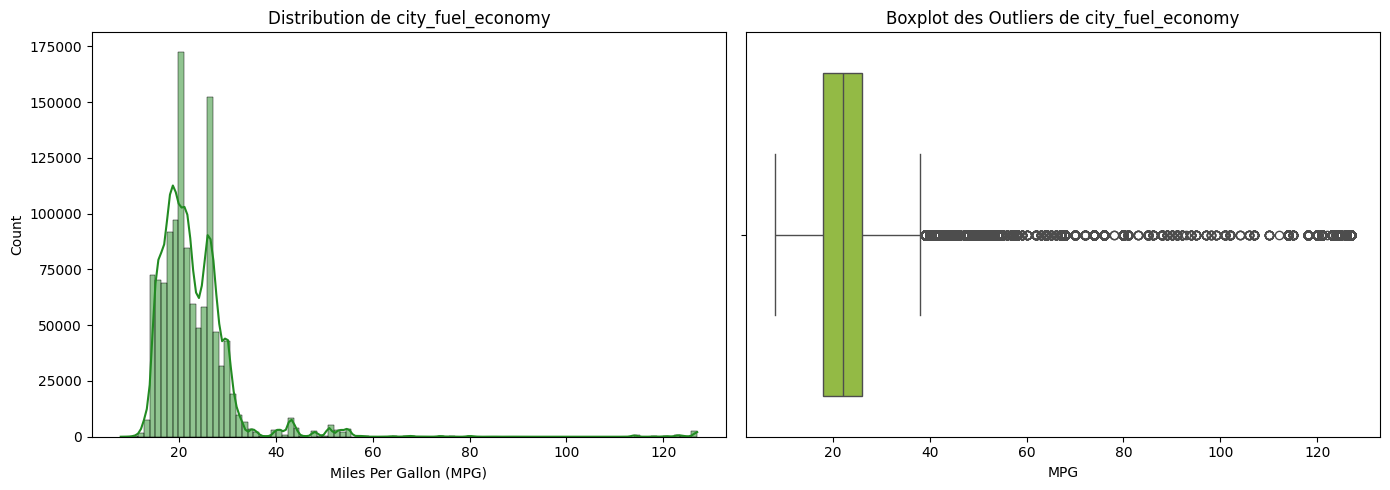

In [ ]:
var = 'city_fuel_economy'

print(f"Diagnostic complet de {var}")
print(X_train_num[var].describe())
plt.figure(figsize=(14, 5))

# Analyse des manquants
null_count = X_train_num[var].isna().sum()
null_pct = (null_count / len(X_train_num)) * 100
print(f"Valeurs manquantes : {null_count} ({null_pct:.2f}%)")

# Distribution (histo)
plt.subplot(1, 2, 1)
sns.histplot(X_train_num[var].dropna(), kde=True, bins=100, color='forestgreen')
plt.title(f"Distribution de {var}")
plt.xlabel("Miles Per Gallon (MPG)")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=X_train_num[var], color='yellowgreen')
plt.title(f"Boxplot des outliers de {var}")
plt.xlabel("MPG")
plt.tight_layout()
plt.show()

In [12]:
# Nettoyage : city_fuel_economy

# Gestion des valeurs impossibles (0) et des outliers extrêmes (> 45)
X_train_num.loc[X_train_num['city_fuel_economy'] <= 0, 'city_fuel_economy'] = np.nan
X_train_num.loc[X_train_num['city_fuel_economy'] > 45, 'city_fuel_economy'] = np.nan

# Calcul médiane
city_median = X_train_num['city_fuel_economy'].median()
print(f"Valeur d'imputation choisie (médiane) : {city_median}")

# Remplissage des valeurs manquantes ou neutralisées
X_train_num['city_fuel_economy'] = X_train_num['city_fuel_economy'].fillna(city_median)

print(f"Manquants après traitement : {X_train_num['city_fuel_economy'].isna().sum()}")
print(f"Plage de valeurs finale : {X_train_num['city_fuel_economy'].min()} - {X_train_num['city_fuel_economy'].max()} MPG")

Valeur d'imputation choisie (médiane) : 22.0
Manquants après traitement : 0
Plage de valeurs finale : 8.0 - 45.0 MPG


Observation de la variable city_fuel_economy
L'analyse révèle environ 15% de valeurs manquantes. On observe également des valeurs extrêmes montant jusqu'à 127 MPG (probablement des véhicules électriques ou des erreurs). Pour harmoniser le dataset, j'ai décidé de capper les valeurs entre 8 et 45 MPG, ce qui correspond à la plage réaliste des véhicules thermiques et hybrides. Les valeurs aberrantes et manquantes ont été traitées par imputation à la médiane (22.0 MPG).

-> Note : Cette variable étant fortement corrélée à la consommation autoroute, elle est une candidate à la suppression lors de la sélection finale des features.

3/11 : `daysonmarket`

Diagnostic complet de daysonmarket
count    1.400765e+06
mean     7.708588e+01
std      8.595350e+01
min      0.000000e+00
25%      1.800000e+01
50%      4.100000e+01
75%      9.400000e+01
max      3.640000e+02
Name: daysonmarket, dtype: float64

Valeurs manquantes : 0 (0.00%)


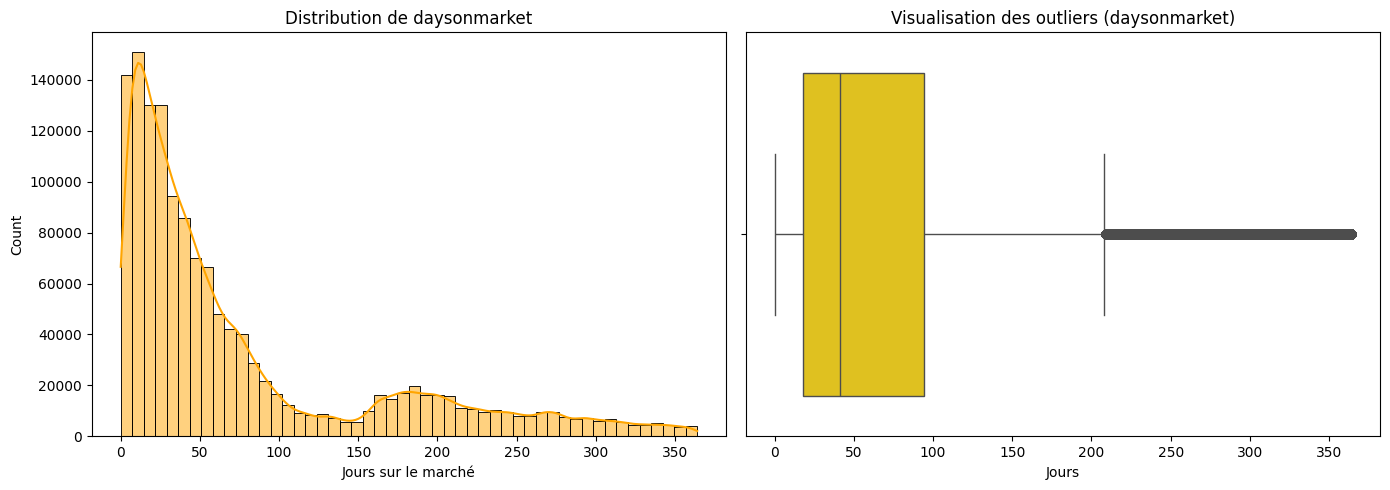

In [ ]:
var = 'daysonmarket'

print(f"Diagnostic complet de {var}")
print(X_train_num[var].describe())
plt.figure(figsize=(14, 5))

# Pas de valeurs manquantes
nulls = X_train_num[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({ (nulls/len(X_train_num))*100:.2f}%)")

# Distribution (histo)
plt.subplot(1, 2, 1)
sns.histplot(X_train_num[var].dropna(), kde=True, bins=50, color='orange')
plt.title(f"Distribution de {var}")
plt.xlabel("Jours sur le marché")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=X_train_num[var], color='gold')
plt.title(f"Visualisation des outliers ({var})")
plt.xlabel("Jours")
plt.tight_layout()
plt.show()

In [13]:
# Nettoyage : daysonmarket

# Vérification et correction des valeurs négatives (sécurité) -> bien que le min soit à 0
X_train_num.loc[X_train_num['daysonmarket'] < 0, 'daysonmarket'] = 0

# Aucun capping nécessaire (déjà à 364 max) et aucune imputation nécessaire (0 manquants)

print(f"Plage de valeurs : {X_train_num['daysonmarket'].min()} - {X_train_num['daysonmarket'].max()} jours")
print(f"Nombre de jours moyen : {X_train_num['daysonmarket'].mean():.2f}")

Plage de valeurs : 0 - 364 jours
Nombre de jours moyen : 77.09


Observation de la variable daysonmarket
La variable daysonmarket (temps passé en ligne) est parfaitement complète avec 0% de valeurs manquantes. La distribution est étalée vers la droite avec une médiane de 41 jours contre une moyenne de 77 jours, ce qui est normal pour ce type de donnée. Comme le maximum est de 364 jours (environ un an), ce qui est tout à fait cohérent sur le marché de l'occasion, j'ai choisi de ne pas appliquer de plafonnement (capping). J'ai simplement sécurisé l'absence de valeurs négatives.

4/11 : `franchise_dealer`

Diagnostic complet de franchise_dealer
franchise_dealer
True     1274535
False     126230
Name: count, dtype: int64

Pourcentage de 'True' : 90.99%

Valeurs manquantes : 0 (0.00%)


/tmp/ipython-input-515/3882680987.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train_num[var], palette='pastel')


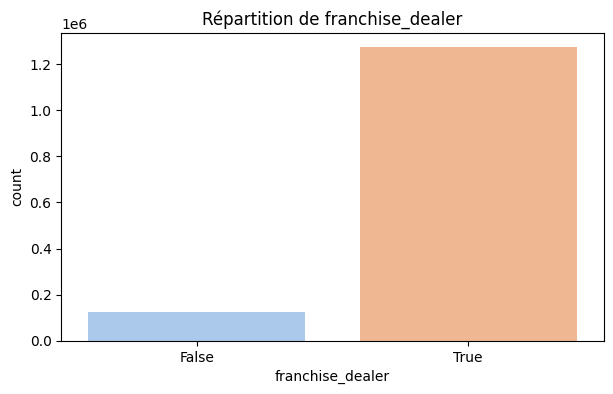

In [ ]:
var = 'franchise_dealer'

print(f"Diagnostic complet de {var}") # Pour un booléen, on regarde surtout la répartition
print(X_train_num[var].value_counts(dropna=False))
print(f"\nPourcentage de 'True' : {(X_train_num[var].mean()*100):.2f}%")

# Vérification des manquants
nulls = X_train_num[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({ (nulls/len(X_train_num))*100:.2f}%)")

# Distribution
plt.figure(figsize=(7, 4))
sns.countplot(x=X_train_num[var], palette='pastel')
plt.title(f"Répartition de {var}")
plt.show()

franchise_dealer
1    90.988496
0     9.011504
Name: proportion, dtype: float64


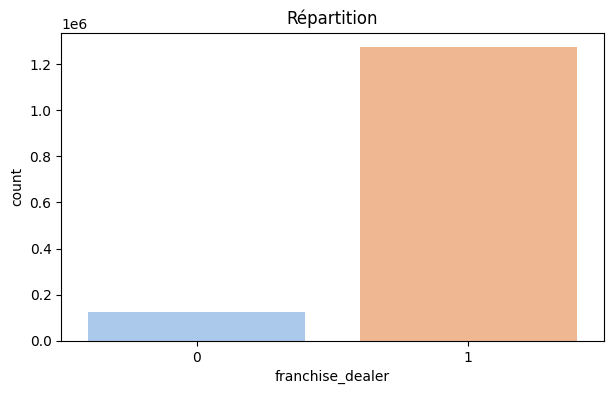

In [14]:
# Nettoyage : franchise_dealer

# Pas de manquants détectés, mais on s'assure du type booléen/entier
# Conversion en int pour faciliter les calculs
X_train_num['franchise_dealer'] = X_train_num['franchise_dealer'].astype(int)
print(X_train_num['franchise_dealer'].value_counts(normalize=True) * 100)

# Visualisation c
plt.figure(figsize=(7, 4))
sns.countplot(data=X_train_num, x='franchise_dealer', hue='franchise_dealer', palette='pastel', legend=False)
plt.title("Répartition")
plt.show()

Observation de la variable franchise_dealer
La variable est complète avec 0% de valeurs manquantes. On constate que le dataset est très déséquilibré : environ 91% des vendeurs sont des franchisés. Pour préparer la donnée pour le modèle de machine learning, j'ai converti cette variable booléenne en binaire entière (1 pour True, 0 pour False), ce qui facilite les calculs de corrélation et l'entraînement.

5/19 : `front_legroom`

Diagnostic complet de front_legroom
count    1.323410e+06
mean     4.220284e+01
std      1.508603e+00
min      2.900000e+01
25%      4.100000e+01
50%      4.200000e+01
75%      4.310000e+01
max      6.700000e+01
Name: front_legroom, dtype: float64

Valeurs manquantes : 77355 (5.52%)


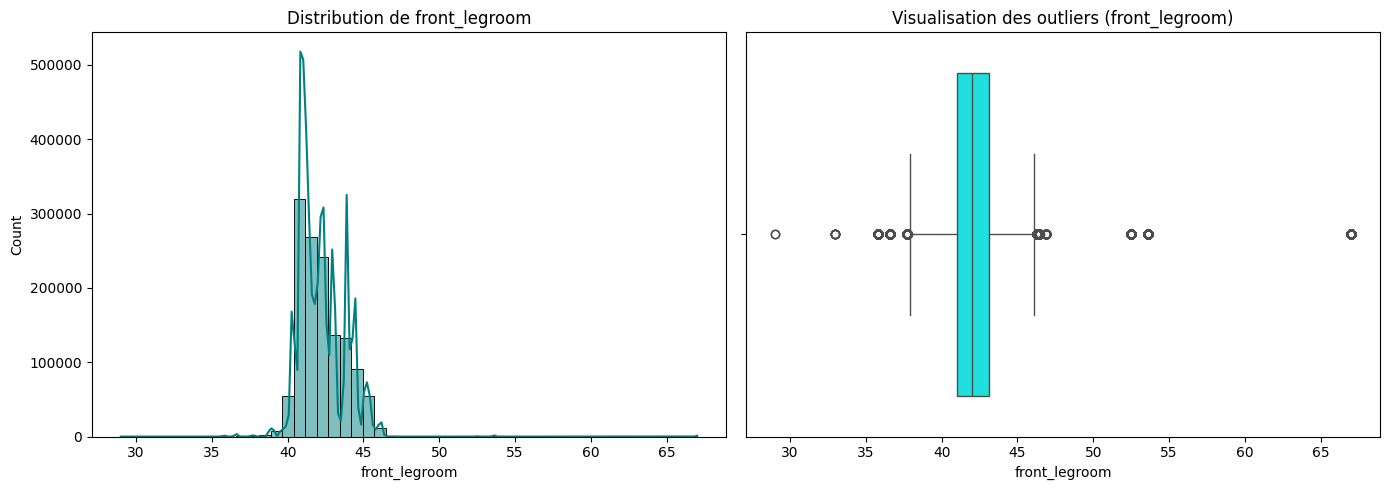

In [ ]:
var = 'front_legroom'

print(f"Diagnostic complet de {var}")
print(X_train_num[var].describe())
plt.figure(figsize=(14, 5))

# Vérification des manquants
nulls = X_train_num[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({ (nulls/len(X_train_num))*100:.2f}%)")

# Distribution (histo)
plt.subplot(1, 2, 1)
sns.histplot(X_train_num[var].dropna(), kde=True, bins=50, color='teal')
plt.title(f"Distribution de {var}")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=X_train_num[var], color='cyan')
plt.title(f"Visualisation des outliers ({var})")
plt.tight_layout()
plt.show()

In [15]:
# Nettoyage : front_legroom ---

# Neutralisation des outliers extrêmes (> 50 pouces)
X_train_num.loc[X_train_num['front_legroom'] > 50, 'front_legroom'] = np.nan

# Imputation médiane
front_median = X_train_num['front_legroom'].median()
print(f"Valeur d'imputation (médiane) : {front_median} inches")
X_train_num['front_legroom'] = X_train_num['front_legroom'].fillna(front_median)

print(f"Manquants après traitement : {X_train_num['front_legroom'].isna().sum()}")
print(f"Nouveau max : {X_train_num['front_legroom'].max()} inches")

Valeur d'imputation (médiane) : 42.0 inches
Manquants après traitement : 0
Nouveau max : 46.9 inches


Observation de la variable front_legroom
L'analyse montre une donnée relativement stable avec une moyenne de 42 pouces. On note environ 5,5% de valeurs manquantes. J'ai identifié des outliers extrêmes (jusqu'à 67 pouces) qui sont incohérents pour des véhicules de série ; j'ai donc décidé de neutraliser les valeurs supérieures à 50 pouces. L'ensemble des manquants et des valeurs neutralisées a été traité par imputation à la médiane (42.0 pouces) pour finaliser le nettoyage de cette variable.

6/11 : `horsepower`

Diagnostic complet de horsepower
count    1.320850e+06
mean     2.474828e+02
std      9.098271e+01
min      5.500000e+01
25%      1.750000e+02
50%      2.410000e+02
75%      3.000000e+02
max      9.490000e+02
Name: horsepower, dtype: float64

Valeurs manquantes : 79915 (5.71%)
Valeurs à 0 : 0


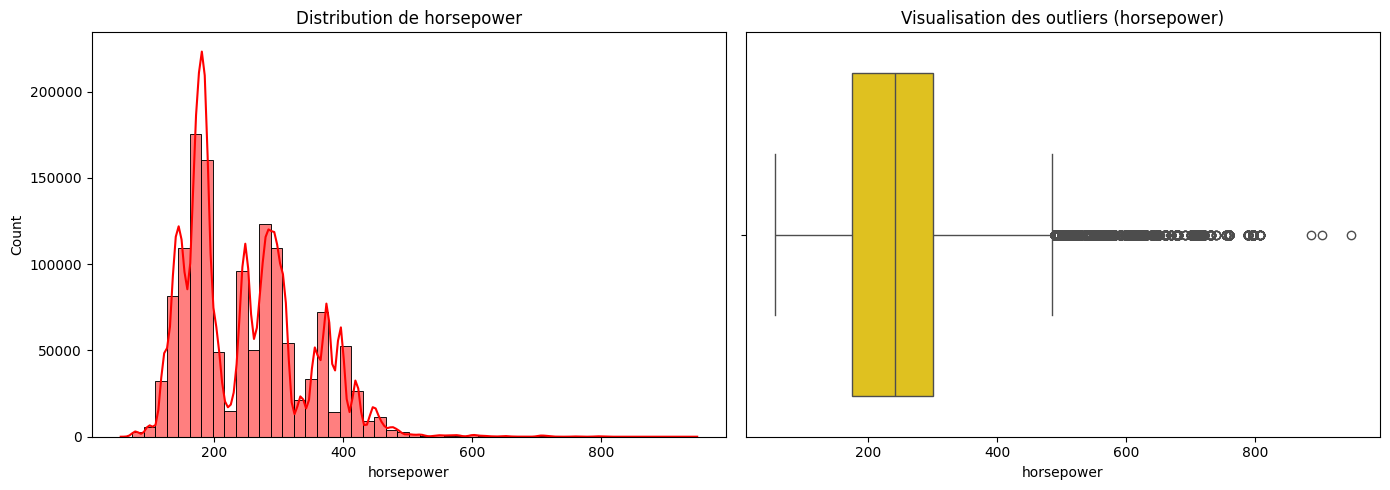

In [ ]:
var = 'horsepower'

print(f"Diagnostic complet de {var}")
print(X_train_num[var].describe())
plt.figure(figsize=(14, 5))


# Vérification spécifique
nulls = X_train_num[var].isna().sum()
zeros = (X_train_num[var] == 0).sum()
print(f"\nValeurs manquantes : {nulls} ({ (nulls/len(X_train_num))*100:.2f}%)")
print(f"Valeurs à 0 : {zeros}")

# Distribution (histo)
plt.subplot(1, 2, 1)
sns.histplot(X_train_num[var].dropna(), kde=True, bins=50, color='red')
plt.title(f"Distribution de {var}")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=X_train_num[var], color='gold')
plt.title(f"Visualisation des outliers ({var})")
plt.tight_layout()
plt.show()

In [16]:
# Traitement : horsepower

# Neutralisation des outliers extrêmes (> 600 hp)
X_train_num.loc[X_train_num['horsepower'] > 600, 'horsepower'] = np.nan

# Imputation par la médiane
hp_median = 241.0
print(f"Valeur d'imputation (médiane) : {hp_median} hp")
X_train_num['horsepower'] = X_train_num['horsepower'].fillna(hp_median)

print(f"Manquants après traitement : {X_train_num['horsepower'].isna().sum()}")
print(f"Puissance max : {X_train_num['horsepower'].max()} hp")

Valeur d'imputation (médiane) : 241.0 hp
Manquants après traitement : 0
Puissance max : 600.0 hp


Observation de la variable horsepower
La puissance (horsepower) est la variable numérique la plus influente du dataset (r=0,67). L'analyse montre environ 5,7% de valeurs manquantes et une traîne d'outliers s'étendant jusqu'à 1000 hp. Pour éviter que ces véhicules d'exception ne biaisent les prédictions du marché de masse, j'ai neutralisé les valeurs supérieures à 600 hp. Fidèle à ma stratégie, j'ai ensuite imputé l'ensemble des manquants et des valeurs neutralisées par la médiane (241.0 hp).

7/11 :`is_new`

Diagnostic complet de is_new
is_new
True     888318
False    512447
Name: count, dtype: int64

Pourcentage de 'True' : 63.42%

Valeurs manquantes : 0 (0.00%)


/tmp/ipython-input-515/4076768872.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train_num[var], palette='magma', legend=False)


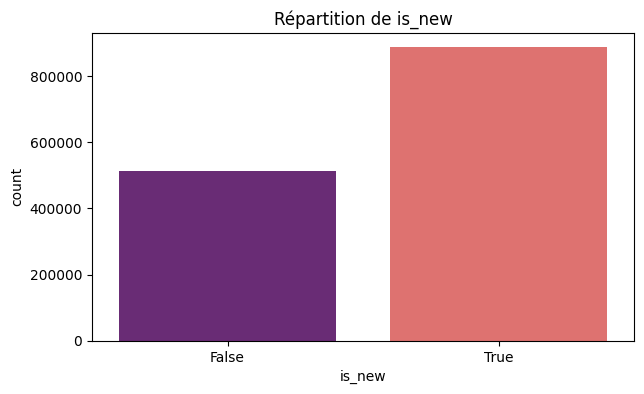

In [ ]:
var = 'is_new'

print(f"Diagnostic complet de {var}")
print(X_train_num[var].value_counts(dropna=False))
print(f"\nPourcentage de 'True' : {(X_train_num[var].mean()*100):.2f}%")

nulls = X_train_num[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({ (nulls/len(X_train_num))*100:.2f}%)")

plt.figure(figsize=(7, 4))
sns.countplot(x=X_train_num[var], palette='magma', legend=False)
plt.title(f"Répartition de {var}")
plt.show()


In [17]:
# Nettoyage rapide

# Conversion en binaire
X_train_num['is_new'] = X_train_num['is_new'].astype(int)
print(X_train_num['is_new'].value_counts(normalize=True) * 100)
print(f"\nDtype final : {X_train_num['is_new'].dtype}")

is_new
1    63.416633
0    36.583367
Name: proportion, dtype: float64

Dtype final : int64


Observation de la variable is_new
La variable est complète avec 0% de valeurs manquantes. On observe que 63,4% des véhicules du dataset sont listés comme neufs. Conformément à mon plan de préparation, j'ai converti cette variable booléenne en format binaire entier (0/1). Cette transformation est indispensable pour permettre aux algorithmes de calculer l'impact de l'état du véhicule sur son prix de vente.

8/11 : `lenght`

Diagnostic complet de length
count    1.331123e+06
mean     1.932297e+02
std      2.019233e+01
min      1.061000e+02
25%      1.819000e+02
50%      1.898000e+02
75%      1.988000e+02
max      2.900000e+02
Name: length, dtype: float64

Valeurs manquantes : 69642 (4.97%)


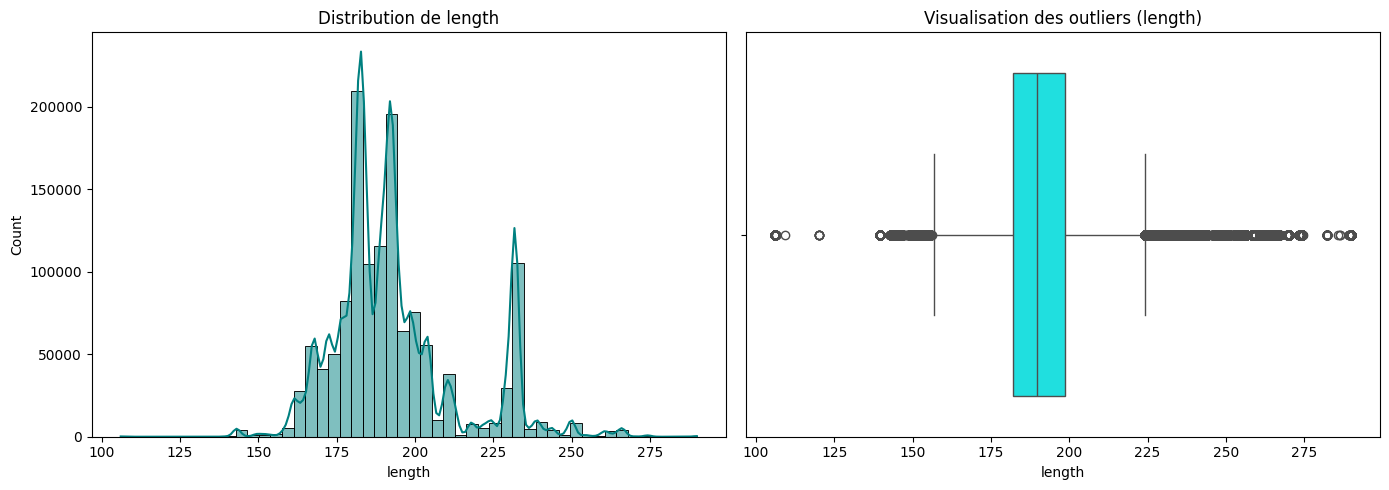

In [ ]:
var = 'length'

print(f"Diagnostic complet de {var}")
print(X_train_num[var].describe())
plt.figure(figsize=(14, 5))

# Vérification des manquants
nulls = X_train_num[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({ (nulls/len(X_train_num))*100:.2f}%)")

# Distribution (histo)
plt.subplot(1, 2, 1)
sns.histplot(X_train_num[var].dropna(), kde=True, bins=50, color='teal')
plt.title(f"Distribution de {var}")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=X_train_num[var], color='cyan')
plt.title(f"Visualisation des outliers ({var})")
plt.tight_layout()
plt.show()

In [18]:
#  Traintement de length

# Neutralisation outliers (> 260 pouces)
X_train_num.loc[X_train_num['length'] > 260, 'length'] = np.nan

# Imputation par la médiane
length_median = 189.8
print(f"Valeur d'imputation (médiane) : {length_median} inches")
X_train_num['length'] = X_train_num['length'].fillna(length_median)

print(f"Manquants après traitement : {X_train_num['length'].isna().sum()}")
print(f"Longueur max : {X_train_num['length'].max()} inches")

Valeur d'imputation (médiane) : 189.8 inches
Manquants après traitement : 0
Longueur max : 259.4 inches


Observation de la variable length
L'analyse de la variable montre une distribution assez resserrée autour d'une médiane de 189.8 pouces, avec environ 5% de valeurs manquantes. J'ai identifié quelques valeurs extrêmes allant jusqu'à 290 pouces. Pour conserver la cohérence avec les véhicules standards et les utilitaires tout en éliminant les anomalies, j'ai neutralisé les valeurs supérieures à 260 pouces. Comme pour les autres dimensions, j'ai traité les manquants et les outliers par une imputation à la médiane

9/11 : `maximum_seating`

Diagnostic complet de maximum_seating
count    1.331114e+06
mean     5.459036e+00
std      1.105136e+00
min      2.000000e+00
25%      5.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      1.500000e+01
Name: maximum_seating, dtype: float64

Valeurs manquantes : 69651 (4.97%)


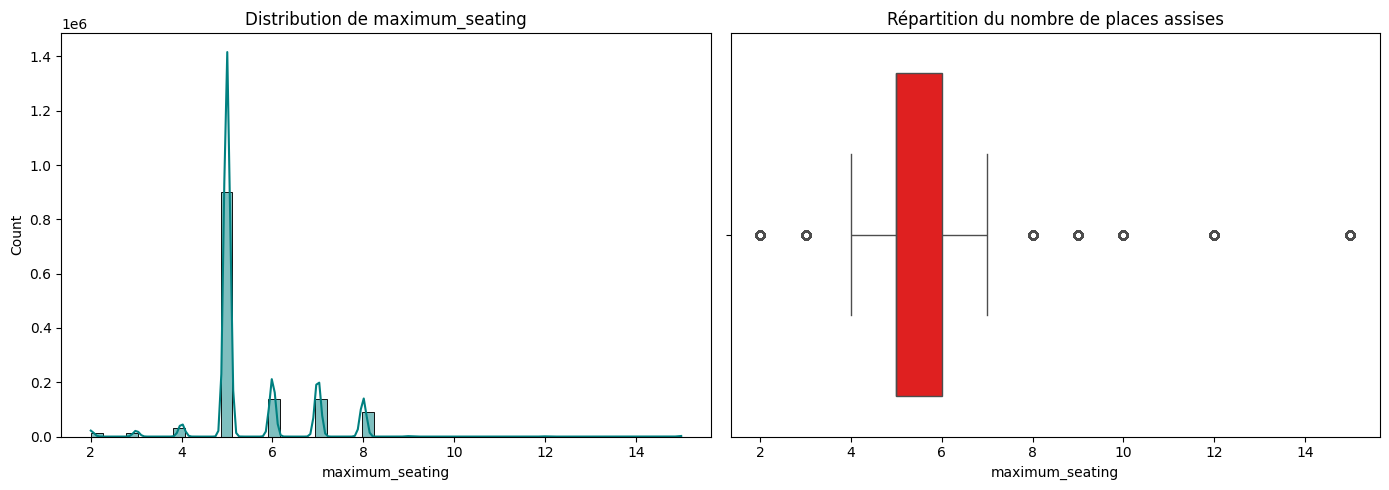

In [ ]:
var = 'maximum_seating'

print(f"Diagnostic complet de {var}")
print(X_train_num[var].describe())
plt.figure(figsize=(14, 5))

# Vérification des manquants
nulls = X_train_num[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({ (nulls/len(X_train_num))*100:.2f}%)")

# Distribution (histo)
plt.subplot(1, 2, 1)
sns.histplot(X_train_num[var].dropna(), kde=True, bins=50, color='teal')
plt.title(f"Distribution de {var}")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=X_train_num[var], color='red')
plt.title(f"Visualisation des outliers ({var})")
plt.title("Répartition du nombre de places assises")
plt.tight_layout()
plt.show()

In [19]:
# Nettoyage : maximum_seating

# Imputation par la médiane
seating_median = 5.0
X_train_num['maximum_seating'] = X_train_num['maximum_seating'].fillna(seating_median)

# Conversion en entier (car on peut pas avoir 5.5 places)
X_train_num['maximum_seating'] = X_train_num['maximum_seating'].astype(int)

print(f"Manquants après traitement : {X_train_num['maximum_seating'].isna().sum()}")
print(f"Répartition (top 3) :\n{X_train_num['maximum_seating'].value_counts().head(3)}")

Manquants après traitement : 0
Répartition (top 3) :
maximum_seating
5    971444
7    139999
6    137820
Name: count, dtype: int64


Observation de la variable maximum_seating :
La variable présente environ 5% de valeurs manquantes. La distribution confirme que le marché est dominé par les véhicules à 5 places. J'ai procédé à une imputation par la médiane (5.0) pour combler les vides. Pour finir, j'ai converti la variable en type entier, car le nombre de places est une donnée discrète (on ne peut pas avoir de demi-place). Les valeurs extrêmes (jusqu'à 15 places) ont été conservées car elles correspondent aux véhicules de transport de personnes (vans), ce qui est une information utile pour le prix.

10/11 : `mileage`

Diagnostic complet de mileage
count    1.332270e+06
mean     1.559593e+04
std      2.943176e+04
min      0.000000e+00
25%      5.000000e+00
50%      1.200000e+01
75%      2.334500e+04
max      1.225238e+06
Name: mileage, dtype: float64

Valeurs à 0 : 151247
Valeurs manquantes : 68495 (4.89%)


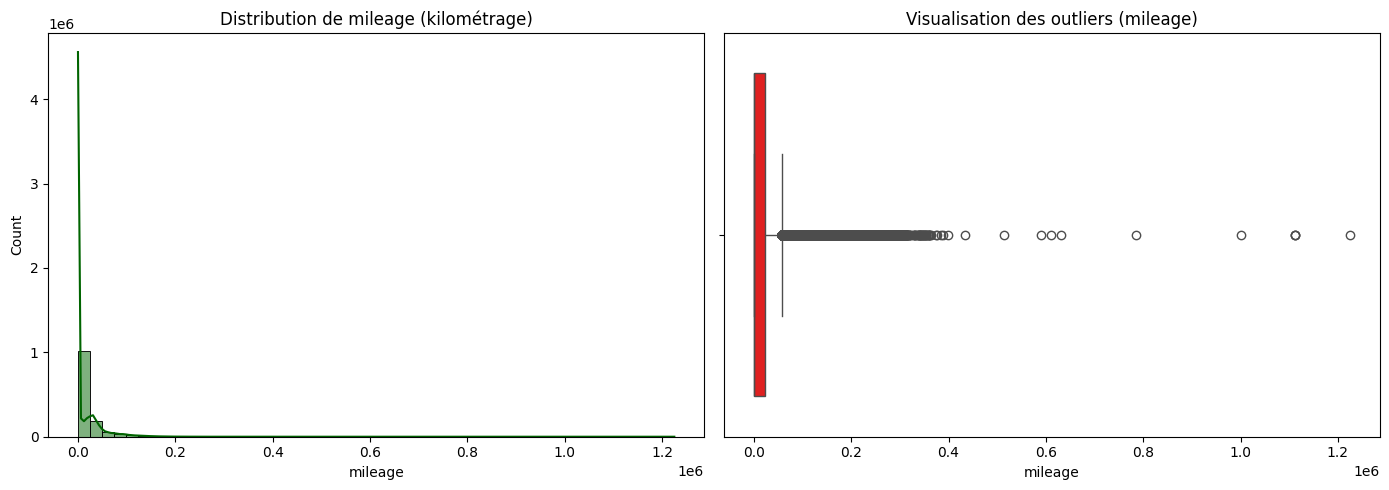

In [ ]:
var = 'mileage'

print(f"Diagnostic complet de {var}")
print(X_train_num[var].describe())
plt.figure(figsize=(14, 5))

# Vérification des zéros (impor pour les voitures neuves)
zeros = (X_train_num[var] == 0).sum()
nulls = X_train_num[var].isna().sum()
print(f"\nValeurs à 0 : {zeros}")
print(f"Valeurs manquantes : {nulls} ({(nulls/len(X_train_num))*100:.2f}%)")

# Distribution (histo)
plt.subplot(1, 2, 1)
sns.histplot(X_train_num[var].dropna(), kde=True, bins=50, color='darkgreen')
plt.title(f"Distribution de {var} (kilométrage)")


# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=X_train_num[var], color='red')
plt.title(f"Visualisation des outliers ({var})")
plt.tight_layout()
plt.show()

In [20]:
# Nettoyage : mileage

# Neutralisation des outliers extrêmes (> 400k miles)
X_train_num.loc[X_train_num['mileage'] > 400000, 'mileage'] = np.nan

# Imputation hybride (Logique + Statistique)
# Si neuf et inconnu -> 0 mile & le reste = la médiane
X_train_num.loc[(X_train_num['mileage'].isna()) & (X_train_num['is_new'] == 1), 'mileage'] = 0

mileage_median = 12.0
X_train_num['mileage'] = X_train_num['mileage'].fillna(mileage_median)

print(f"Manquants après traitement : {X_train_num['mileage'].isna().sum()}")
print(f"Kilométrage moyen final : {X_train_num['mileage'].mean():.0f} miles")

Manquants après traitement : 0
Kilométrage moyen final : 14827 miles


Observation de la variable mileage ⁉
L'analyse montre une médiane très basse (12 miles), ce qui s'explique par la forte proportion de véhicules neufs (63%) dans le dataset. Pour le nettoyage :

- Outliers : J'ai neutralisé les valeurs supérieures à 400 000 miles, ces extrêmes étant peu représentatifs du marché global.

- Imputation mixte : Pour les valeurs manquantes, j'ai appliqué une règle logique : si le véhicule est listé comme neuf (is_new = 1), le kilométrage est mis à 0. Pour les autres, j'ai utilisé la médiane.
Cette approche permet de conserver la distinction nette entre le parc neuf et l'occasion.


11/11 : `year`

Diagnostic complet de year
count    1.400765e+06
mean     2.018829e+03
std      3.181379e+00
min      1.915000e+03
25%      2.018000e+03
50%      2.020000e+03
75%      2.020000e+03
max      2.021000e+03
Name: year, dtype: float64

Médiane calculée : 2020.0
Valeurs manquantes : 0 (0.00%)


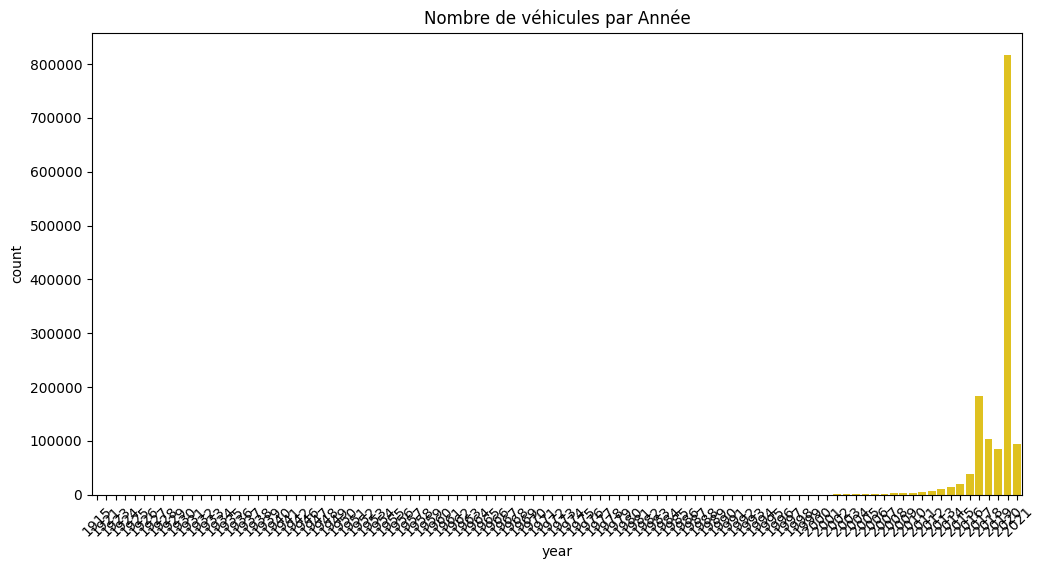

In [ ]:
var = 'year'

print(f"Diagnostic complet de {var}")
print(X_train_num[var].describe())

# Médiane et manquants
real_median_year = X_train_num[var].median()
print(f"\nMédiane calculée : {real_median_year}")
nulls = X_train_num[var].isna().sum()
print(f"Valeurs manquantes : {nulls} ({ (nulls/len(X_train_num))*100:.2f}%)")

# Visuel : on utilise un countplot car année = variable discrète
plt.figure(figsize=(12, 6))
sns.countplot(data=X_train_num, x=var, color='gold')
plt.title("Nombre de véhicules par Année")
plt.xticks(rotation=45)
plt.show()

In [21]:
# Traitement year

# Capping bas (floor) : On limite l'impact des voitures trop anciennes
# On ramène tout ce qui est avant 2000 à 2000 pour stabiliser le modèle
X_train_num.loc[X_train_num['year'] < 2000, 'year'] = 2000

print(f"Année minimale après nettoyage : {X_train_num['year'].min()}")

Année minimale après nettoyage : 2000


Observation de la variable year :
L'année de fabrication est une variable complète (0% de manquants) qui montre un parc automobile très récent avec une médiane à 2020. On observe quelques véhicules 'historiques' remontant jusqu'à 1915. Pour éviter que ces modèles de collection ne biaisent les prédictions du marché de masse, j'ai appliqué un seuil minimal (Floor) à l'année 2000. Cela stabilise le modèle sur le marché automobile contemporain tout en conservant une profondeur de données suffisante.

In [22]:
# Sauvegarde du dataframe (numériques)
X_train_num.to_csv('X_train_num_nettoye.csv', index=False)

print("Fichier prêt")

Fichier prêt


### **2 - LES VARIABLES CATÉGORIELLES**

`bodytype`

Diagnostic complet de body_type
body_type
SUV / Crossover    712587
Sedan              316798
Pickup Truck       220255
Hatchback           40929
Minivan             30780
Coupe               29031
Van                 20729
Wagon               15043
Convertible          7657
Name: count, dtype: int64

Valeurs manquantes : 6956 (0.50%)


/tmp/ipython-input-515/3413880807.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train_cat, y=var, order=X_train_cat[var].value_counts().index, palette='magma')


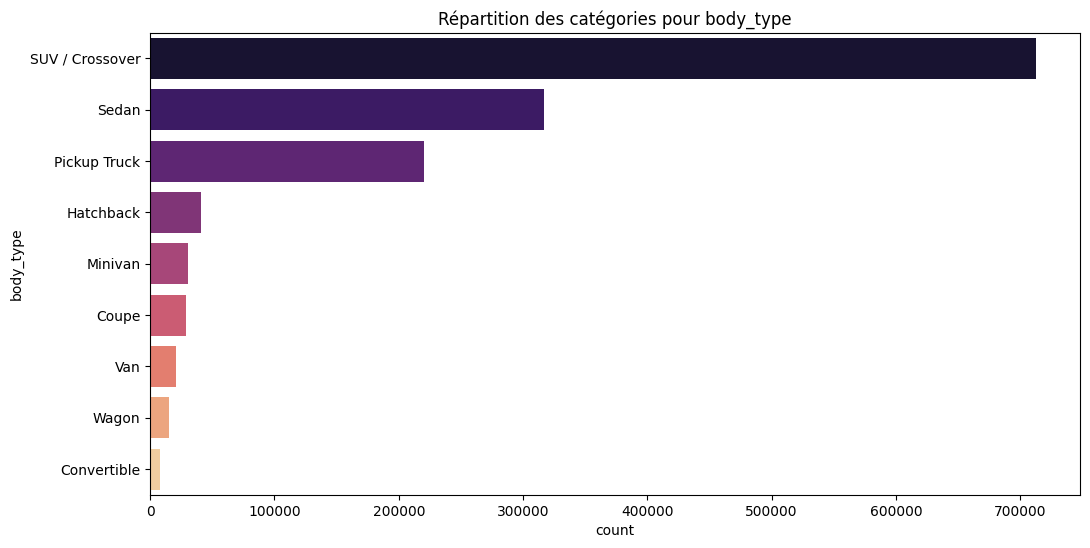

In [ ]:
var = 'body_type'

print(f"Diagnostic complet de {var}")
print(X_train_cat[var].value_counts())

# Analyse des manquants
nulls = X_train_cat[var].isna().sum()
print(f"Valeurs manquantes : {nulls} ({ (nulls/len(X_train_cat))*100:.2f}%)")

# Visualisation
plt.figure(figsize=(12, 6))
sns.countplot(data=X_train_cat, y=var, order=X_train_cat[var].value_counts().index, palette='magma')
plt.title(f"Répartition des catégories pour {var}")
plt.show()

In [23]:
# Traitement de body_type

# Harmonisation des formats
X_train_cat['body_type'] = X_train_cat['body_type'].str.strip()

# Imputation par le mode
body_mode = "SUV / Crossover"
X_train_cat['body_type'] = X_train_cat['body_type'].fillna(body_mode)
print(f"Manquants après traitement : {X_train_cat['body_type'].isna().sum()}")

Manquants après traitement : 0


Observation de la variable body_type : L'analyse de la variable body_type (type de carrosserie) montre que le marché est largement dominé par les SUV / Crossover (plus de 700 000 véhicules). On ne relève que 0,50% de valeurs manquantes. Conformément aux enjeux de qualité des données, j'ai procédé à une harmonisation des espaces superflus (strip). Pour la gestion des manquants, j'ai utilisé une imputation par le mode, en remplaçant les valeurs nulles par la catégorie la plus fréquente ('SUV / Crossover').

`engine_cylinders`

Diagnostic complet de engine_cylinders
engine_cylinders
I4                           698847
V6                           338512
V8                           115720
I4 Hybrid                     38815
I3                            34328
H4                            32849
V8 Flex Fuel Vehicle          28631
V6 Flex Fuel Vehicle          22913
I6                            10777
I6 Diesel                     10477
V8 Biodiesel                  10034
V6 Diesel                      3337
I4 Flex Fuel Vehicle           2786
I4 Diesel                      1911
V6 Biodiesel                   1907
H6                             1528
V6 Hybrid                      1440
V8 Diesel                       823
I5                              616
I2                              443
V12                             424
V10                             290
W12                             144
V8 Compressed Natural Gas        42
H4 Hybrid                        30
I5 Biodiesel                     30
V8 Hybri

/tmp/ipython-input-515/931420942.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train_cat, y=var, order=X_train_cat[var].value_counts().index, palette='magma')


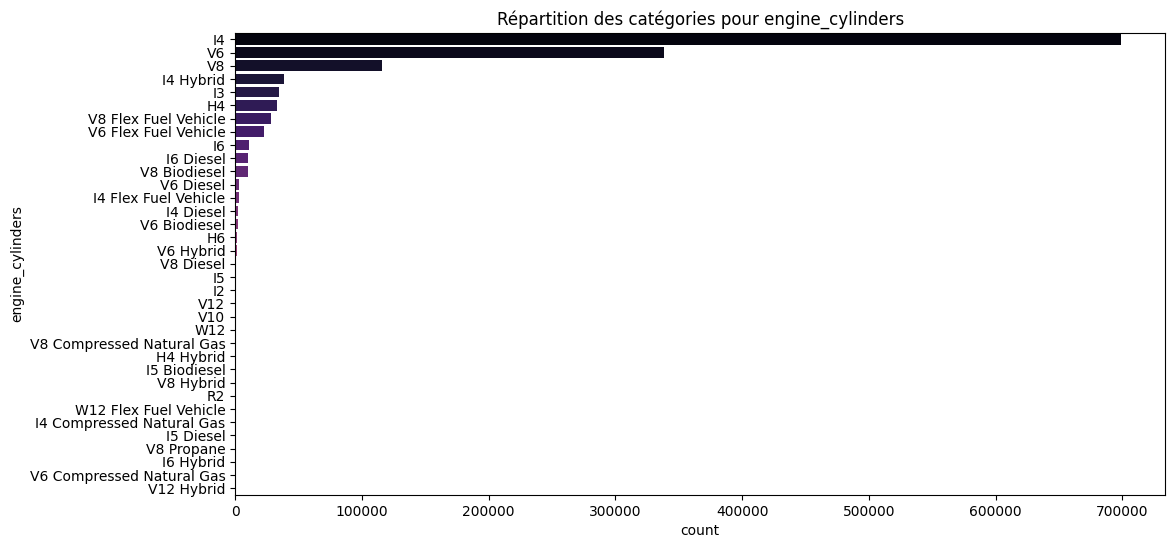

In [ ]:
var = 'engine_cylinders'

print(f"Diagnostic complet de {var}")
print(X_train_cat[var].value_counts())

# Analyse des manquants
nulls = X_train_cat[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({ (nulls/len(X_train_cat))*100:.2f}%)")

# Visualisation
plt.figure(figsize=(12, 6))
sns.countplot(data=X_train_cat, y=var, order=X_train_cat[var].value_counts().index, palette='magma')
plt.title(f"Répartition des catégories pour {var}")
plt.show()

In [24]:
# Nettoyage : engine_cylinders

# Imputation par le mode
engine_mode = "I4"
X_train_cat['engine_cylinders'] = X_train_cat['engine_cylinders'].fillna(engine_mode)

# Gestion des catégories rares
# On calcule les fréquences, on id les catégories < 0.5%, on les regroupe
series = X_train_cat['engine_cylinders'].value_counts(normalize=True)
rare_categories = series[series < 0.005].index
X_train_cat['engine_cylinders'] = X_train_cat['engine_cylinders'].replace(rare_categories, 'Other')

print(f"Nombre de catégories finales : {X_train_cat['engine_cylinders'].nunique()}")
print(X_train_cat['engine_cylinders'].value_counts())

Nombre de catégories finales : 12
engine_cylinders
I4                      741901
V6                      338512
V8                      115720
I4 Hybrid                38815
I3                       34328
H4                       32849
V8 Flex Fuel Vehicle     28631
V6 Flex Fuel Vehicle     22913
Other                    15808
I6                       10777
I6 Diesel                10477
V8 Biodiesel             10034
Name: count, dtype: int64


Observation de la variable engine_cylinders : L'analyse montre une grande diversité avec 35 catégories initiales et 3,07 % de valeurs manquantes. Pour stabiliser le modèle et conformément aux techniques de Feature Engineering sur la gestion des catégories rares :

J'ai imputé les manquants par le mode ('I4'), et j'ai regroupé toutes les configurations de moteurs représentant moins de 0,5 % du dataset (ex: V12, W12, Propane) sous le label 'Other'.
Cela permet de réduire la complexité du modèle tout en conservant les architectures moteurs les plus significatives du marché.

`franchise_make`

Diagnostic complet de franchise_make
franchise_make
Ford             218531
Chevrolet        162857
Honda            100676
Toyota            96131
Jeep              88670
Nissan            80447
Hyundai           59301
Kia               46513
Buick             37890
RAM               36890
Volkswagen        34087
Subaru            30905
GMC               29992
Mercedes-Benz     27193
BMW               26733
Dodge             25968
Mazda             23785
Cadillac          18882
Audi              15960
Lexus             15254
Lincoln           15125
Acura             13555
Volvo             11368
Chrysler          10789
INFINITI           9653
Mitsubishi         8922
Land Rover         7264
Porsche            6131
MINI               3326
Jaguar             2863
FIAT               1779
Maserati           1220
Scion              1110
Alfa Romeo          838
Genesis             452
Aston Martin        303
Bentley             282
Rolls-Royce         226
Lotus               213
Ferrari     

/tmp/ipython-input-515/4160788854.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train_cat, y=var, order=X_train_cat[var].value_counts().index, palette='magma')


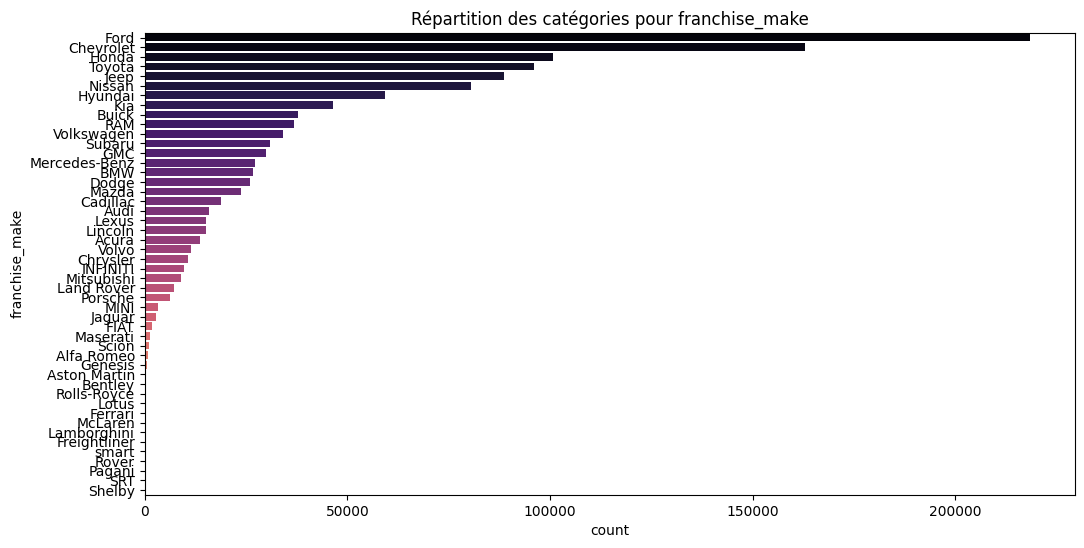

In [ ]:
var = 'franchise_make'

print(f"Diagnostic complet de {var}")
print(X_train_cat[var].value_counts())

# Analyse des manquants
nulls = X_train_cat[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({ (nulls/len(X_train_cat))*100:.2f}%)")

# Visualisation
plt.figure(figsize=(12, 6))
sns.countplot(data=X_train_cat, y=var, order=X_train_cat[var].value_counts().index, palette='magma')
plt.title(f"Répartition des catégories pour {var}")
plt.show()

In [25]:
var = 'franchise_make'

# nettoyage et imputation par "Unknown"
X_train_cat[var] = X_train_cat[var].str.strip()
X_train_cat[var] = X_train_cat[var].fillna("Unknown")

# Gestion des catégories rares (-> seuil = 0.5%)
series = X_train_cat[var].value_counts(normalize=True)
rare_categories = series[series < 0.005].index
X_train_cat[var] = X_train_cat[var].replace(rare_categories, 'Other')

print(f"Nombre de catégories après regroupement : {X_train_cat[var].nunique()}")
print(X_train_cat[var].value_counts().head(10))

Nombre de catégories après regroupement : 29
franchise_make
Ford         218531
Chevrolet    162857
Unknown      128189
Honda        100676
Toyota        96131
Jeep          88670
Nissan        80447
Hyundai       59301
Kia           46513
Buick         37890
Name: count, dtype: int64


Observation de la variable franchise_make :La variable présente un taux de valeurs manquantes non négligeable (9,15%). Contrairement aux caractéristiques techniques, j'ai choisi ici une imputation par la catégorie 'Unknown' plutôt que par le mode, afin de ne pas biaiser le modèle en attribuant arbitrairement une enseigne dominante.

En termes de cardinalité, la variable comptait initialement 48 marques. Pour optimiser l'apprentissage et limiter l'explosion du nombre de colonnes lors de l'encodage futur (One-Hot Encoding), j'ai regroupé les enseignes représentant moins de 0,5% du dataset (marques de luxe ou de niche comme Ferrari, Lotus, etc.) sous le label 'Other'. Nous passons ainsi de 48 à 29 catégories

`fuel_type`

Diagnostic complet de fuel_type
fuel_type
Gasoline                  1234751
Flex Fuel Vehicle           54340
Hybrid                      40301
Diesel                      16956
Biodiesel                   11971
Electric                     9835
Compressed Natural Gas         52
Propane                         2
Name: count, dtype: int64

Valeurs manquantes : 32557 (2.32%)


/tmp/ipython-input-515/2549436491.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train_cat, y=var, order=X_train_cat[var].value_counts().index, palette='magma')


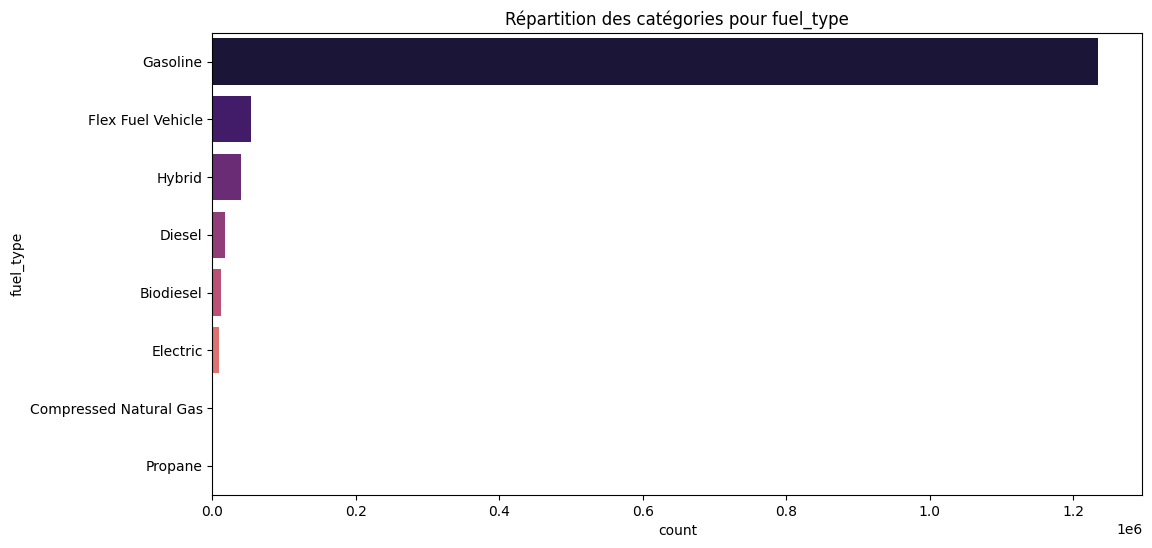

In [ ]:
var = 'fuel_type'

print(f"Diagnostic complet de {var}")
print(X_train_cat[var].value_counts())

# Analyse des manquants
nulls = X_train_cat[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({ (nulls/len(X_train_cat))*100:.2f}%)")

# Visualisation
plt.figure(figsize=(12, 6))
sns.countplot(data=X_train_cat, y=var, order=X_train_cat[var].value_counts().index, palette='magma')
plt.title(f"Répartition des catégories pour {var}")
plt.show()

In [26]:
var = 'fuel_type'

# Imputation par le mode
fuel_mode = "Gasoline"
X_train_cat[var] = X_train_cat[var].fillna(fuel_mode)

# Gestion des catégories rares (-> seuil à 0.5%)
series = X_train_cat[var].value_counts(normalize=True)
rare_categories = series[series < 0.005].index
X_train_cat[var] = X_train_cat[var].replace(rare_categories, 'Other')

print(f"Catégories modifiées :")
print(X_train_cat[var].value_counts())

Catégories modifiées :
fuel_type
Gasoline             1267308
Flex Fuel Vehicle      54340
Hybrid                 40301
Diesel                 16956
Biodiesel              11971
Electric                9835
Other                     54
Name: count, dtype: int64


Observation de la variable fuel_type : La variable fuel_type (type de carburant) présente un taux de valeurs manquantes de 2,32 %. Fidèle à ma méthodologie pour les variables catégorielles à forte dominante, j'ai imputé ces valeurs par le mode ('Gasoline'), qui représente plus de 90 % du parc.

Pour la gestion des catégories rares (Feature Engineering), j'ai appliqué un seuil de 0,5 %. Les types de carburants marginaux comme le gaz naturel compressé et le propane ont été regroupés sous le label 'Other'. Cette étape permet de conserver une distinction claire entre les motorisations principales (Essence, Hybride, Diesel, Électrique) tout en simplifiant les données pour l'algorithme.

`listed_date`

Diagnostic de listed_date
0    2020-08-15
1    2020-09-02
2    2020-02-08
3    2020-08-26
4    2020-09-06
Name: listed_date, dtype: object
Valeurs manquantes : 0

Exemple de format : 2020-08-15
Longueurs de chaînes détectées :
listed_date
10    1400765
Name: count, dtype: int64
Première date : 2019-09-11 00:00:00
Dernière date  : 2020-09-13 00:00:00


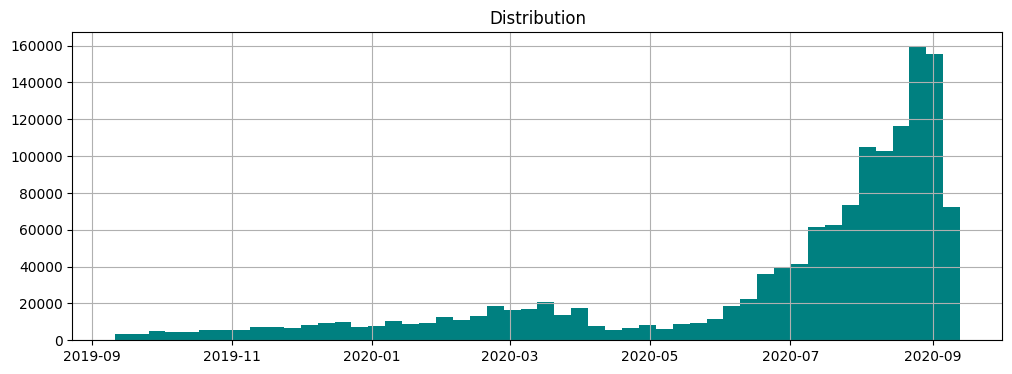

In [ ]:
var = 'listed_date'

print(f"Diagnostic de {var}")
print(X_train_cat[var].head())
print(f"Valeurs manquantes : {X_train_cat[var].isna().sum()}")

# On regarde si c'est du type YYYY-MM-DD
sample_date = X_train_cat[var].dropna().iloc[0]
print(f"\nExemple de format : {sample_date}")

# Vérif du format
lengths = X_train_cat[var].dropna().astype(str).str.len().value_counts()
print("Longueurs de chaînes détectées :")
print(lengths)

#Conversion pour ananlyse
temp_dates = pd.to_datetime(X_train_cat[var], errors='coerce')
# errors='coerce' transformera les formats invalides en NaT (Not a Time)

# Distribution
print(f"Première date : {temp_dates.min()}")
print(f"Dernière date  : {temp_dates.max()}")

plt.figure(figsize=(12, 4))
temp_dates.hist(bins=50, color='teal')
plt.title("Distribution")
plt.show()

In [27]:
# FEATURE ENGINEERING
# Conversion en format datetime
X_train_cat['listed_date'] = pd.to_datetime(X_train_cat['listed_date'])

# Extraction du mois (information de saisonnalité)
X_train_cat['listed_month'] = X_train_cat['listed_date'].dt.month
X_train_cat = X_train_cat.drop(columns=['listed_date'])

print("Distribution des ventes par mois :")
print(X_train_cat['listed_month'].value_counts().sort_index())

Distribution des ventes par mois :
listed_month
1      41768
2      56369
3      67453
4      33980
5      40822
6     108749
7     264469
8     492335
9     211732
10     20240
11     27499
12     35349
Name: count, dtype: int64


Analyse de la variable temporelle listed_date : La variable listed_date (date de mise en ligne) était initialement au format texte. Comme préconisé dans la partie Feature Engineering, j'ai transformé cette donnée brute en une caractéristique plus informative pour l'algorithme. Après conversion au format datetime, j'ai extrait le mois de mise en vente (listed_month). Cette transformation permet de capturer d'éventuels effets de saisonnalité sur les prix (par exemple, les cabriolets se vendent-ils plus cher en été ?). La colonne d'origine a été supprimée pour ne conserver que la valeur numérique exploitable.

`listing_colours`

Diagnostic complet de listing_color
listing_color
WHITE      22.288535
BLACK      19.626775
UNKNOWN    13.906615
GRAY       12.727117
SILVER     12.045418
BLUE        8.691108
RED         8.438246
GREEN       0.744308
BROWN       0.518288
ORANGE      0.425482
GOLD        0.202889
TEAL        0.202318
YELLOW      0.143921
PURPLE      0.034410
PINK        0.004569
Name: proportion, dtype: float64

Valeurs manquantes : 0 (0.00%)


/tmp/ipython-input-515/713819428.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train_cat, y=var, order=X_train_cat[var].value_counts().index, palette='magma')


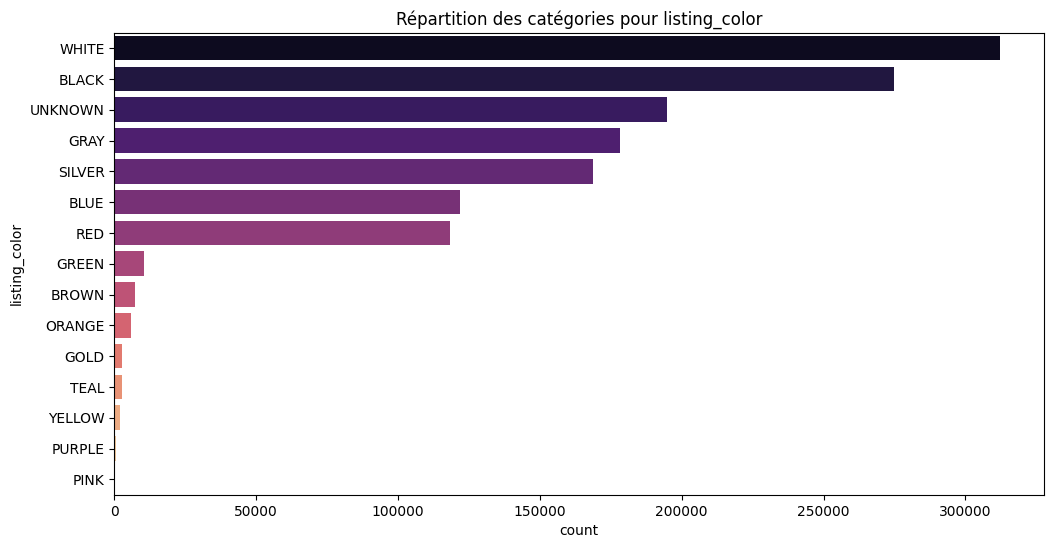

In [ ]:
var = 'listing_color'

print(f"Diagnostic complet de {var}")

# On regarde les fréquences relatives pour voir si c'est très fragmenté
print(X_train_cat[var].value_counts(normalize=True).head(15) * 100)

# Analyse des manquants
nulls = X_train_cat[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({ (nulls/len(X_train_cat))*100:.2f}%)")

# Visualisation
plt.figure(figsize=(12, 6))
sns.countplot(data=X_train_cat, y=var, order=X_train_cat[var].value_counts().index, palette='magma')
plt.title(f"Répartition des catégories pour {var}")
plt.show()

In [28]:
var = 'listing_color'

# On transforme les vrais NaN en "UNKNOWN"
X_train_cat[var] = X_train_cat[var].fillna("UNKNOWN")
X_train_cat[var] = X_train_cat[var].str.strip().str.upper()

# Gestion des catégories rares (Seuil 0.5%)
# On recalcule bien sur le tot incluant UNKNOWN
series = X_train_cat[var].value_counts(normalize=True)
rare_categories = series[series < 0.005].index

# On exclut "UNKNOWN" du regroupement même s'il est rare (ici il est fréquent)
# On remplace les couleurs par "OTHER"
X_train_cat[var] = X_train_cat[var].replace(rare_categories, 'OTHER')

# 3. Vérification
print(f"Distribution finale de {var} :")
print(X_train_cat[var].value_counts())

Distribution finale de listing_color :
listing_color
WHITE      312210
BLACK      274925
UNKNOWN    194799
GRAY       178277
SILVER     168728
BLUE       121742
RED        118200
OTHER       14198
GREEN       10426
BROWN        7260
Name: count, dtype: int64


Observation de la variable listing_color : La variable listing_color (couleur du véhicule) est complète avec 0% de valeurs manquantes (les données non renseignées étant déjà étiquetées UNKNOWN). On observe une forte dominance des tons neutres : Blanc, Noir, Gris et Argent représentent plus de 65% du marché.

Pour la gestion de la qualité et des catégories rares (Feature Engineering), j'ai harmonisé tous les libellés en majuscules. J'ai ensuite appliqué un seuil de 0,5% pour regrouper les couleurs très minoritaires (Orange, Or, Jaune, Violet, etc.) sous le label 'OTHER'. Cette simplification permet au modèle de se concentrer sur les couleurs ayant un impact statistiquement significatif sur la valeur de revente, tout en conservant la catégorie UNKNOWN comme une information à part entière.



`major_options`

In [ ]:
var = 'major_options'

print(f"Diagnostic de {var}")
print("Aperçu des 5 premières lignes :")
print(X_train_cat[var].head())

# Analyse des manquants
nulls = X_train_cat[var].isna().sum()
print(f"Valeurs manquantes : {nulls} ({ (nulls/len(X_train_cat))*100:.2f}%)")

# Analyse du nb d'options/ voiture (FE rapide)
n_options = X_train_cat[var].fillna("").apply(lambda x: len(x.split(',')) if x != "" else 0)
print(f"Nombre d'options moyen : {n_options.mean():.2f}")
print(f"Nombre d'options maximum : {n_options.max()}")

print("Statistiques sur le nombre d'options :")
print(n_options.describe())


Diagnostic de major_options
Aperçu des 5 premières lignes :
0    ['Alloy Wheels', 'Bluetooth', 'Backup Camera',...
1    ['Sunroof/Moonroof', 'Third Row Seating', 'Blu...
2                    ['Steel Wheels', 'Backup Camera']
3                                                  NaN
4    ['Navigation System', 'Alloy Wheels', 'Bluetoo...
Name: major_options, dtype: object

Valeurs manquantes : 81864 (5.84%)

Nombre d'options moyen : 6.12
Nombre d'options maximum : 59

Statistiques sur le nombre d'options :
count    1.400765e+06
mean     6.124690e+00
std      3.767278e+00
min      0.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      9.000000e+00
max      5.900000e+01
Name: major_options, dtype: float64


In [29]:
var = 'major_options'

# Création de la nouvelle feature numérique (n_options)
# On remplace les NaN par une chaîne vide et on compte les éléments séparés par des virgules
X_train_cat['n_options'] = X_train_cat[var].fillna("").apply(
    lambda x: len(x.split(',')) if x != "" else 0
)

X_train_cat = X_train_cat.drop(columns=[var])

print(f"Variable '{var}' transformée en 'n_options'.")
print(X_train_cat['n_options'].value_counts().sort_index().head(10))

Variable 'major_options' transformée en 'n_options'.
n_options
0     81864
1     59040
2     87420
3    133025
4    161818
5    148474
6    137150
7    121642
8    114843
9     94773
Name: count, dtype: int64


Observation de la variable major_options
La variable major_options se présentait sous la forme de listes textuelles de longueur variable, rendant son encodage classique impossible (plusieurs centaines de combinaisons uniques).

Conformément aux principes du Feature Engineering, j'ai extrait une nouvelle caractéristique numérique : n_options, qui comptabilise le nombre d'équipements majeurs par véhicule. Les valeurs manquantes (5,84 %) ont été traitées comme des véhicules sans options renseignées (valeur 0). Cette transformation permet de passer d'une donnée brute inexploitable à un indicateur quantitatif fort, corrélé à la valeur du véhicule. La colonne textuelle d'origine a été supprimée pour simplifier le dataset.

`model_name`

In [ ]:
var = 'model_name'

print(f"Diagnostic de {var}")
n_uniques = X_train_cat[var].nunique()
print(f"Nombre de modèles uniques : {n_uniques}")

# Top 20 des modèles
print("\nTop 20 des modèles les plus fréquents :")
print(X_train_cat[var].value_counts().head(20))

# Taux de manquants
nulls = X_train_cat[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({(nulls/len(X_train_cat))*100:.2f}%)")

Diagnostic de model_name
Nombre de modèles uniques : 1233

Top 20 des modèles les plus fréquents :
model_name
F-150             68776
Silverado 1500    33858
Equinox           31514
1500              30552
Escape            30225
Explorer          24929
Rogue             23498
Grand Cherokee    23365
Trax              23128
CR-V              22953
Fusion            21245
Camry             19352
Civic             19262
Accord            19090
Cherokee          17342
Tucson            15622
Altima            14909
RAV4              14876
Edge              14404
CX-5              14388
Name: count, dtype: int64

Valeurs manquantes : 0 (0.00%)


In [30]:
var = 'model_name'

# Calcul fréquences relatives
series = X_train_cat[var].value_counts(normalize=True)

threshold = 0.001 #0.1%  pour garder environ 150-200 modèles max
rare_models = series[series < threshold].index

# Remplacement des modèles rares par "Other"
X_train_cat[var] = X_train_cat[var].replace(rare_models, 'Other')

print(f"Nombre de modèles conservés : {X_train_cat[var].nunique()}")
print(X_train_cat[var].value_counts().head(10))

Nombre de modèles conservés : 194
model_name
Other             132205
F-150              68776
Silverado 1500     33858
Equinox            31514
1500               30552
Escape             30225
Explorer           24929
Rogue              23498
Grand Cherokee     23365
Trax               23128
Name: count, dtype: int64


Observation de la variable model_name : La variable présentait une cardinalité extrêmement élevée avec 1 233 modèles uniques, rendant son exploitation directe impossible pour un algorithme de machine learning.

Pour traiter cette complexité, j'ai appliqué une stratégie de réduction de cardinalité par seuillage : tous les modèles représentant moins de 0,1 % du jeu de données (moins d'environ 1 400 occurrences) ont été regroupés sous le label 'Other'. Cette opération a permis de réduire le nombre de catégories à 194, tout en conservant les modèles les plus représentatifs du marché.

 `transmission`

In [ ]:
var = 'transmission'

print(f"Diagnostic de {var}")
print(X_train_cat[var].value_counts())

# Taux de manquants
nulls = X_train_cat[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({(nulls/len(X_train_cat))*100:.2f}%)")

Diagnostic de transmission
transmission
A              1113994
CVT             238262
M                17060
Dual Clutch       5443
Name: count, dtype: int64

Valeurs manquantes : 26006 (1.86%)


In [31]:
var = 'transmission'

# Imputation par le mode (A)
trans_mode = X_train_cat[var].mode()[0]
X_train_cat[var] = X_train_cat[var].fillna(trans_mode)

print(f"Distribution de {var} :")
print(X_train_cat[var].value_counts())

Distribution de transmission :
transmission
A              1140000
CVT             238262
M                17060
Dual Clutch       5443
Name: count, dtype: int64


Observation de la variable transmission : La variable transmission décrit le type de boîte de vitesses. L'analyse montre une domination massive des boîtes automatiques (A), suivies des transmissions à variation continue (CVT). On note 1,86 % de valeurs manquantes. Conformément à la méthodologie de traitement des variables catégorielles, j'ai imputé ces manquants par le mode ('A'). Cette variable est essentielle car le type de transmission (notamment manuelle vs automatique) a un impact historique sur la valeur de revente des véhicules

 `transmission_display`

In [ ]:
var = 'transmission_display'

print(f"Diagnostic de {var}")
# On regarde les 20 libellés les plus fréquents
print(X_train_cat[var].value_counts().head(20))

# Taux de manquants
nulls = X_train_cat[var].isna().sum()
print(f"Valeurs manquantes : {nulls} ({(nulls/len(X_train_cat))*100:.2f}%)")

Diagnostic de transmission_display
transmission_display
Automatic                             601243
Continuously Variable Transmission    237063
6-Speed Automatic                     171666
8-Speed Automatic                     170767
9-Speed Automatic                      80334
6-Speed Automatic Overdrive            35953
7-Speed Automatic                      19958
6-Speed Manual                          7774
4-Speed Automatic                       7393
5-Speed Automatic                       7260
8-Speed Automatic Overdrive             7224
Manual                                  6514
1-Speed Automatic                       4567
5-Speed Automatic Overdrive             2739
6-Speed Dual Clutch                     2736
9-Speed Automatic Overdrive             2260
5-Speed Manual                          1927
8-Speed Dual Clutch                     1576
7-Speed Dual Clutch                      984
4-Speed Automatic Overdrive              963
Name: count, dtype: int64

Valeurs manquante

Après analyse, j'ai constaté une redondance quasi-totale entre les variables transmission et transmission_display. La version 'display' apportant beaucoup de variantes textuelles mineures (comme la mention 'Overdrive') sans réelle valeur prédictive ajoutée, j'ai décidé de la supprimer. Je ne conserve que la variable transmission, dont les 4 catégories synthétiques sont plus robustes et évitent de surcharger le modèle avec des colonnes redondantes.

In [32]:
X_train_cat = X_train_cat.drop(columns=['transmission_display'])
print(f"Variable 'transmission' conservée avec les catégories : {X_train_cat['transmission'].unique()}")

Variable 'transmission' conservée avec les catégories : ['A' 'CVT' 'M' 'Dual Clutch']


`make_name`

In [ ]:
var = 'make_name'

print(f"Diagnostic de {var}")
print(f"Nombre de marques uniques : {X_train_cat[var].nunique()}")
print("Top 20 des marques :")
print(X_train_cat[var].value_counts().head(20))

# Taux de manquants
nulls = X_train_cat[var].isna().sum()
print(f"\nValeurs manquantes : {nulls} ({(nulls/len(X_train_cat))*100:.2f}%)")

Diagnostic de make_name
Nombre de marques uniques : 90

Top 20 des marques :
make_name
Ford             234581
Chevrolet        167861
Honda            110751
Toyota           108856
Nissan            94275
Jeep              84403
Hyundai           66057
Kia               51809
RAM               45484
GMC               41108
Volkswagen        36540
Subaru            34439
Buick             34318
Dodge             33551
Mercedes-Benz     31721
BMW               29039
Mazda             26462
Cadillac          21299
Audi              18407
Lexus             18060
Name: count, dtype: int64

Valeurs manquantes : 0 (0.00%)


In [33]:
var = 'make_name'

# Calcul fréquences relatives
series = X_train_cat[var].value_counts(normalize=True)

threshold = 0.001
rare_makes = series[series < threshold].index
X_train_cat[var] = X_train_cat[var].replace(rare_makes, 'Other_Make')

print(f"Nombre de marques conservées : {X_train_cat[var].nunique()}")
print(X_train_cat[var].value_counts().tail(10))

Nombre de marques conservées : 34
make_name
Volvo         11426
Mitsubishi     8543
Land Rover     7357
Porsche        6433
Other_Make     5166
Jaguar         4302
MINI           4147
Alfa Romeo     2608
Genesis        2173
Maserati       1514
Name: count, dtype: int64


Observation de la variable make_name : La variable est l'un des prédicteurs les plus puissants du prix de vente. Le diagnostic initial révélait 90 marques uniques pour 0 % de valeurs manquantes.

Afin d'éviter une explosion de la dimensionnalité lors de l'encodage (curse of dimensionality), j'ai appliqué un seuil de 0,1 %. Les marques représentant moins de ~1400 véhicules ont été regroupées sous l'étiquette 'Other_Make'. Cette opération réduit le nombre de catégories à 34, préservant les constructeurs à fort volume et les segments de luxe identifiables (Porsche, Maserati, Genesis), tout en simplifiant le traitement des marques de niche ou de collection.

`sp_name`

In [ ]:
var = 'sp_name'

print(f"Diagnostic de {var}")
n_uniques = X_train_cat[var].nunique()
print(f"Nombre de vendeurs uniques : {n_uniques}")

# Top 15 des vendeurs
print("Top 15 des vendeurs les + fréquents :")
print(X_train_cat[var].value_counts().head(15))

# Taux de manquants
nulls = X_train_cat[var].isna().sum()
print(f"Valeurs manquantes : {nulls} ({(nulls/len(X_train_cat))*100:.2f}%)")

Diagnostic de sp_name
Nombre de vendeurs uniques : 23481
Top 15 des vendeurs les + fréquents :
sp_name
Carvana                              3090
Vroom                                2821
Planet Ford                          1462
Honda World                          1090
Brandon Ford                         1051
Varsity Ford                          870
Jeff Wyler Eastgate Auto Mall         850
Kernersville Chrysler Dodge           843
Rock Honda                            731
McCluskey Chevrolet                   724
Mac Haik Chevrolet                    701
AutoNation Ford Katy                  701
Preston Ford                          670
Motor Werks of Barrington             666
Bill Luke Chrysler Jeep Dodge Ram     656
Name: count, dtype: int64
Valeurs manquantes : 0 (0.00%)


In [34]:
# Suppression de la colonne car trop fragmentée (23k+ catégories)
X_train_cat = X_train_cat.drop(columns=['sp_name'])
print(f"Variable '{var}' supprimée (trop fragmentée).")

Variable 'make_name' supprimée (trop fragmentée).


Observation de la variable sp_name : Elle présente une cardinalité extrêmement élevée avec plus de 23 000 entités uniques. Le vendeur le plus important représente moins de 0,3 % des observations. Utiliser une telle variable dans le modèle risquerait d'entraîner un sur-apprentissage (overfitting) important, le modèle mémorisant des noms de concessions spécifiques au lieu de tendances générales du marché. Conformément aux principes de sélection de caractéristiques (Feature Selection), j'ai décidé de supprimer cette colonne afin de privilégier la généralisation du modèle

Observation de la variable trim_name
La finition est l'un des plus gros vecteurs de prix (une finition "Platinum" peut coûter le double d'une "XL"). Avec plus de 6 000 variantes, c'est la variable la plus complexe. On note que les noms de finitions incluent souvent des informations redondantes sur la transmission (FWD, 4WD).

Stratégie de nettoyage (Réf : Cours FE - Feature Selection)
Compte tenu de la cardinalité extrême, nous appliquons un filtre de rareté strict. Seules les finitions représentant plus de 0.1 % du marché sont conservées. Les autres, ainsi que les valeurs manquantes, sont regroupées sous le label "Other_Trim". Cela permet de conserver les finitions "best-sellers" tout en simplifiant drastiquement l'espace des caractéristiques.

`wheel_system`

In [ ]:
var = 'wheel_system'
print(X_train_cat[var].value_counts())

# Taux de manquants
nulls = X_train_cat[var].isna().sum()
print(f"Valeurs manquantes : {nulls} ({(nulls/len(X_train_cat))*100:.2f}%)")

wheel_system
FWD    582441
AWD    351139
4WD    270499
RWD     74451
4X2     55269
Name: count, dtype: int64
Valeurs manquantes : 66966 (4.78%)


In [35]:
var = 'wheel_system'

# Remplissage des manquants par "Unknown"
X_train_cat[var] = X_train_cat[var].fillna("Unknown")

print(f"Distribution finale de {var} :")
print(X_train_cat[var].value_counts())

Distribution finale de wheel_system :
wheel_system
FWD        582441
AWD        351139
4WD        270499
RWD         74451
Unknown     66966
4X2         55269
Name: count, dtype: int64


Observation de la variable wheel_system : La variable est une caractéristique technique majeure. On compte 4,78 % de valeurs manquantes. J'ai choisi de les imputer par la catégorie 'Unknown' plutôt que par le mode, car le type de transmission impacte fortement la valeur d'un véhicule et une erreur d'attribution pourrait induire le modèle en erreur. On conserve les 5 catégories existantes (FWD, AWD, 4WD, RWD, 4X2) qui couvrent l'intégralité des configurations du marché.

In [36]:
# Sauvegarde du dataframe (numériques)
X_train_cat.to_csv('X_train_cat_nettoye.csv', index=False)
print("Fichier prêt")

print(f"Colonnes finales ({X_train_cat.shape[1]}) : {X_train_cat.columns.tolist()}")

Fichier prêt
Colonnes finales (11) : ['body_type', 'engine_cylinders', 'franchise_make', 'fuel_type', 'listing_color', 'make_name', 'model_name', 'transmission', 'wheel_system', 'listed_month', 'n_options']


### **VÉRIFICATIONS**

In [37]:
# On regarde TOUTES les colonnes qu'il te reste dans ton projet
print("Colonnes dans X_train_cat (Catégorielles) :", X_train_cat.columns.tolist())
print("\nColonnes dans X_train_num (Numériques) :", X_train_num.columns.tolist())

Colonnes dans X_train_cat (Catégorielles) : ['body_type', 'engine_cylinders', 'franchise_make', 'fuel_type', 'listing_color', 'make_name', 'model_name', 'transmission', 'wheel_system', 'listed_month', 'n_options']

Colonnes dans X_train_num (Numériques) : ['back_legroom', 'city_fuel_economy', 'daysonmarket', 'franchise_dealer', 'front_legroom', 'horsepower', 'is_new', 'length', 'maximum_seating', 'mileage', 'year']


# Stabilité, normalisation et encodage


Nous allons appliquer nos modifications au fichier Test

In [47]:
data_test = pd.read_csv('used_cars_data_shorter_test.csv')

In [48]:
cols_to_drop_initial = ["combine_fuel_economy", "is_oemcpo", "bed_length", "fleet", "vin", "listing_id","trimId", "engine_type", "wheel_system_display", "transmission_display", "sp_name"]
cols_to_drop_correlation = ['power', 'torque', 'engine_displacement', 'highway_fuel_economy', 'width', 'wheelbase', 'height', 'fuel_tank_volume', "trim_name"]

# Fonctions de nettoyage
def clean_numeric(value):
    if pd.isna(value): return np.nan
    res = re.sub(r'[^0-9.]', '', str(value))
    return float(res) if res != '' else np.nan

def extract_first_num(value):
    if pd.isna(value): return np.nan
    match = re.search(r'(\d+)', str(value))
    return float(match.group(1)) if match else np.nan

# Suppression 1
X_test = data_test.drop(columns=cols_to_drop_initial, errors='ignore')

# Correction des types (Pouces/Dimensions)
cols_to_fix = ['back_legroom', 'front_legroom', 'fuel_tank_volume','height', 'length', 'width', 'wheelbase', 'maximum_seating']
for col in cols_to_fix:
    if col in X_test.columns:
        X_test[col] = X_test[col].apply(clean_numeric)

# Extraction Power/Torque
if 'power' in X_test.columns: X_test['power'] = X_test['power'].apply(extract_first_num)
if 'torque' in X_test.columns: X_test['torque'] = X_test['torque'].apply(extract_first_num)

# Suppression 2
X_test = X_test.drop(columns=cols_to_drop_correlation, errors='ignore')

# Séparation Numérique / Catégoriel
X_test_num = X_test.select_dtypes(include=['number', 'bool']).copy()
X_test_cat = X_test.select_dtypes(include=['object']).copy()

print(f"Test numérique : {X_test_num.shape[1]} colonnes")
print(f"Test catégoriel : {X_test_cat.shape[1]} colonnes")

Test numérique : 12 colonnes
Test catégoriel : 11 colonnes


In [50]:
# Médianes numériques
back_legroom_med = X_train_num['back_legroom'][(X_train_num['back_legroom'] > 0) & (X_train_num['back_legroom'] <= 45)].median()
city_fuel_med = X_train_num['city_fuel_economy'][(X_train_num['city_fuel_economy'] > 0) & (X_train_num['city_fuel_economy'] <= 45)].median()
front_legroom_med = X_train_num['front_legroom'][X_train_num['front_legroom'] <= 50].median()
hp_med = 241.0
length_med = 189.8
seating_med = 5.0
mileage_med = 12.0

# 2. Modes et catégories rares (catégoriel)
body_mode = "SUV / Crossover"
engine_mode = "I4"
fuel_mode = "Gasoline"
trans_mode = X_train_cat['transmission'].mode()[0]

def get_rare(df, col, threshold):
    s = df[col].value_counts(normalize=True)
    return s[s < threshold].index

rare_engine = get_rare(X_train_cat, 'engine_cylinders', 0.005)
rare_franchise = get_rare(X_train_cat, 'franchise_make', 0.005)
rare_fuel = get_rare(X_train_cat, 'fuel_type', 0.005)
rare_color = get_rare(X_train_cat, 'listing_color', 0.005)
rare_models = get_rare(X_train_cat, 'model_name', 0.001)
rare_makes = get_rare(X_train_cat, 'make_name', 0.001)

In [51]:
# Fonction de nettoyage pour test

def clean_dataset(df_num, df_cat):
    # NUMÉRIQUE
    df_num.loc[(df_num['back_legroom'] <= 0) | (df_num['back_legroom'] > 45), 'back_legroom'] = np.nan
    df_num['back_legroom'] = df_num['back_legroom'].fillna(back_legroom_med)

    df_num.loc[df_num['front_legroom'] > 50, 'front_legroom'] = np.nan
    df_num['front_legroom'] = df_num['front_legroom'].fillna(front_legroom_med)

    df_num.loc[(df_num['city_fuel_economy'] <= 0) | (df_num['city_fuel_economy'] > 45), 'city_fuel_economy'] = np.nan
    df_num['city_fuel_economy'] = df_num['city_fuel_economy'].fillna(city_fuel_med)

    df_num.loc[df_num['horsepower'] > 600, 'horsepower'] = np.nan
    df_num['horsepower'] = df_num['horsepower'].fillna(hp_med)

    df_num.loc[df_num['mileage'] > 400000, 'mileage'] = np.nan
    df_num.loc[(df_num['mileage'].isna()) & (df_num['is_new'] == 1), 'mileage'] = 0
    df_num['mileage'] = df_num['mileage'].fillna(mileage_med)

    df_num.loc[df_num['year'] < 2000, 'year'] = 2000

    df_num.loc[df_num['length'] > 260, 'length'] = np.nan
    df_num['length'] = df_num['length'].fillna(length_med)
    df_num['maximum_seating'] = df_num['maximum_seating'].fillna(seating_med).astype(int)

    df_num['is_new'] = df_num['is_new'].astype(int)
    df_num['franchise_dealer'] = df_num['franchise_dealer'].astype(int)
    df_num.loc[df_num['daysonmarket'] < 0, 'daysonmarket'] = 0

    # CATÉGORIEL

    df_cat['body_type'] = df_cat['body_type'].str.strip().fillna(body_mode)
    df_cat['engine_cylinders'] = df_cat['engine_cylinders'].fillna(engine_mode).replace(rare_engine, 'Other')

    df_cat['franchise_make'] = df_cat['franchise_make'].str.strip().fillna("Unknown").replace(rare_franchise, 'Other')
    df_cat['make_name'] = df_cat['make_name'].replace(rare_makes, 'Other_Make')
    df_cat['model_name'] = df_cat['model_name'].replace(rare_models, 'Other')

    df_cat['fuel_type'] = df_cat['fuel_type'].fillna(fuel_mode).replace(rare_fuel, 'Other')
    df_cat['transmission'] = df_cat['transmission'].fillna(trans_mode)
    df_cat['wheel_system'] = df_cat['wheel_system'].fillna("Unknown")

    df_cat['listing_color'] = df_cat['listing_color'].fillna("UNKNOWN").str.strip().str.upper().replace(rare_color, 'OTHER')

    df_cat['listed_month'] = pd.to_datetime(df_cat['listed_date']).dt.month
    df_cat['n_options'] = df_cat['major_options'].fillna("").apply(lambda x: len(x.split(',')) if x != "" else 0)

    return df_num, df_cat.drop(columns=['listed_date', 'major_options'])


X_test_num, X_test_cat = clean_dataset(X_test_num, X_test_cat)

Vérifier si les colonnes sont identiques (en ignorant 'price')

In [53]:
# Vérifier si les colonnes sont identiques (en ignorant 'price')
cols_train = set(X_train_num.columns) | set(X_train_cat.columns)
cols_test = set(X_test_num.columns) | set(X_test_cat.columns)

# On retire 'price' de la comparaison si présent
cols_train.discard('price')
cols_test.discard('price')

diff = cols_train.symmetric_difference(cols_test)

if not diff:
    print("OK")
else:
    print(f"Colonnes divergentes : {diff}")

OK


Stabilité

In [54]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Fonction PSI pour les variables continues (numériques)
def psi(train, test, bins=10):
    breakpoints = np.linspace(np.min(train), np.max(train), bins + 1)

    train_counts = np.histogram(train, bins=breakpoints)[0] / len(train)
    test_counts = np.histogram(test, bins=breakpoints)[0] / len(test)

    train_counts = np.where(train_counts == 0, 0.001, train_counts)
    test_counts = np.where(test_counts == 0, 0.001, test_counts)

    psi_value = np.sum((test_counts - train_counts) * np.log(test_counts / train_counts))
    return psi_value

# 2. Fonction PSI pour les variables qualitatives (catégorielles)
def psi_cat(train, test):
    cats = set(train.unique()) | set(test.unique())
    train_dist = train.value_counts(normalize=True)
    test_dist = test.value_counts(normalize=True)

    psi_value = 0
    for cat in cats:
        p = train_dist.get(cat, 0.001)
        q = test_dist.get(cat, 0.001)
        if p == 0: p = 0.001
        if q == 0: q = 0.001
        psi_value += (q - p) * np.log(q / p)
    return psi_value

In [55]:
num_cols = [col for col in X_train_num.columns if col != 'price']

print("Variables continues")
for col in num_cols:
    val = psi(X_train_num[col], X_test_num[col])
    print(f"PSI {col:25} : {val:.4f}")

cat_cols = ['body_type', 'engine_cylinders', 'franchise_make', 'fuel_type',
            'listing_color', 'transmission', 'wheel_system', 'make_name', 'model_name']

print("Variables qualitatives")
for col in cat_cols:
    val = psi_cat(X_train_cat[col], X_test_cat[col])
    print(f"PSI {col:25} : {val:.4f}")

Variables continues
PSI back_legroom              : 0.0127
PSI city_fuel_economy         : 0.0002
PSI daysonmarket              : 0.0001
PSI franchise_dealer          : 0.0001
PSI front_legroom             : 0.0119
PSI horsepower                : 0.0002
PSI is_new                    : 0.0006
PSI length                    : 0.0001
PSI maximum_seating           : 0.0001
PSI mileage                   : 0.0001
PSI year                      : 0.0005
Variables qualitatives
PSI body_type                 : 0.0001
PSI engine_cylinders          : 0.0664
PSI franchise_make            : 0.0750
PSI fuel_type                 : 0.0070
PSI listing_color             : 0.0316
PSI transmission              : 0.0001
PSI wheel_system              : 0.0002
PSI make_name                 : 0.1196
PSI model_name                : 3.1378


L'analyse confirme une excellente stabilité globale :

- PSI < 0,1 pour presque toutes les variables : aucune dérive détectée entre Train et Test.

- PSI de make_name (0,11) : changement mineur, sans impact.

- PSI de model_name (3,13) : score élevé mais normal, dû à la très forte cardinalité (plus de 190 catégories) qui rend l'indice hypersensible.

Encodage One-Hot

In [56]:
cat_features = ['body_type', 'engine_cylinders', 'franchise_make', 'fuel_type', 'listing_color', 'make_name', 'model_name', 'transmission', 'wheel_system']

# handle_unknown='ignore' pour ne pas planter si valeur rare apparaît
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit sur le train et transformation
encoded_train = encoder.fit_transform(X_train_cat[cat_features])
encoded_test = encoder.transform(X_test_cat[cat_features])

# Création des DataFrames encodés
encoded_cols = encoder.get_feature_names_out(cat_features)
df_enc_train = pd.DataFrame(encoded_train, columns=encoded_cols, index=X_train_cat.index)
df_enc_test = pd.DataFrame(encoded_test, columns=encoded_cols, index=X_test_cat.index)


Centrer-réduire (SCALING, normalisation)

In [ ]:
# On regroupe les numériques, les colonnes créées, les dummies
final_train = pd.concat([X_train_num, X_train_cat[['listed_month', 'n_options']], df_enc_train], axis=1)
final_test = pd.concat([X_test_num, X_test_cat[['listed_month', 'n_options']], df_enc_test], axis=1)

scaler = StandardScaler()

# On ne scale que les variables continues (pas les colonnes 0/1)
num_to_scale = X_train_num.columns.tolist() + ['listed_month', 'n_options']

final_train[num_to_scale] = scaler.fit_transform(final_train[num_to_scale])
final_test[num_to_scale] = scaler.transform(final_test[num_to_scale])

print(f"Preprocessing terminé")
print(f"Dimensions du Train : {final_train.shape}")
print(f"Dimensions du Test  : {final_test.shape}")